Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import statsmodels.api as sm
from datetime import timedelta
from itertools import combinations

# Modelling imports
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns_general_width   = 16
sns_general_height  = 8
sns.set(rc={'figure.figsize':(sns_general_width, sns_general_height)})
POPULATION_THRESHOLD = 1000000

## ETL

Utilities

In [3]:
# Special codes with the exception of Kosovo (OWID_KOS)
special_owid_codes = ('OWID_AFR', 'OWID_ASI', 'OWID_EUR', 'OWID_EUN', 'OWID_HIC',
       'OWID_INT', 'OWID_LIC', 'OWID_LMC', 'OWID_NAM',
       'OWID_CYN', 'OWID_OCE', 'OWID_SAM', 'OWID_UMC', 'OWID_WRL')

In [4]:
def plot_full(countries, df, title, metric, date="date"):
    for country in countries:
        _df = df[df['country'] == country]
        plt.plot(_df[date], _df[metric])
    plt.title(title)
    plt.ylabel(metric.replace('_', ' ').title())
    plt.xlabel('Time')

def plot_summary(df, title, metric, date='date', remove_mean=False):
    if not remove_mean:
        df = df.groupby(date).agg(
                mean=(metric,"mean"), 
                median=(metric,"median"),
                percentile_5=(metric, lambda x: np.nanpercentile(x, 5)),
                percentile_95=(metric, lambda x: np.nanpercentile(x, 95))
            ).reset_index()
    else:
        df = df.groupby(date).agg(
                median=(metric,"median"),
                percentile_5=(metric, lambda x: np.nanpercentile(x, 5)),
                percentile_95=(metric, lambda x: np.nanpercentile(x, 95))
            ).reset_index()
    df.plot(df.columns[0], df.columns[1:]) # date vs mean, median, 5th, 95th
    plt.title(title)
    plt.ylabel(metric.replace('_', ' ').title())
    plt.xlabel('Time')

### Stringency

In [5]:
# stringency_df = pd.read_csv('data/stringency/covid-stringency-index.csv')
stringency_df = pd.read_csv('data/general/owid-covid-data.csv')[['location', 'iso_code', 'date', 'stringency_index']]
stringency_df.rename(columns={
    # "Entity":"country",
    "location":"country",
    # "Code":"code",
    "iso_code":"code",
    # "Day":"date"
    },
    inplace=True)

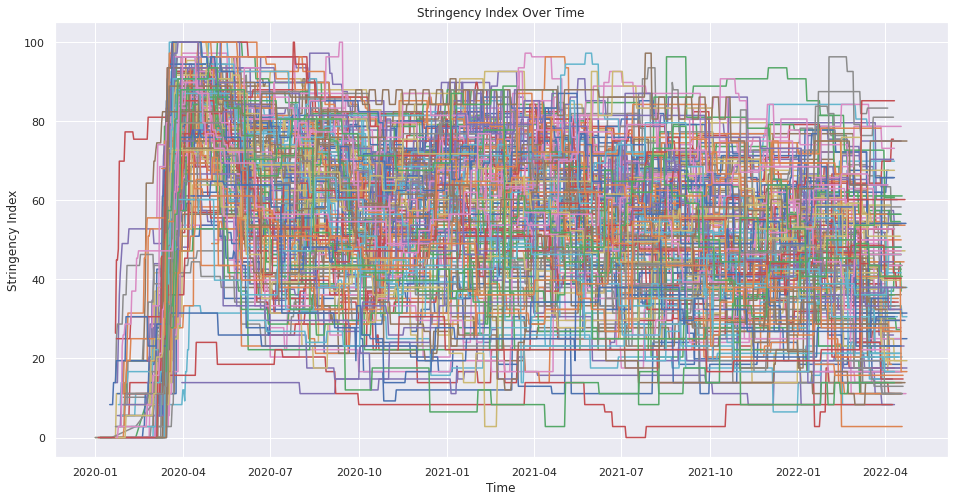

In [6]:
countries = stringency_df['country'].unique()
stringency_df['date'] = pd.to_datetime(stringency_df['date'])
plot_full(countries, stringency_df, title='Stringency Index Over Time', metric='stringency_index')

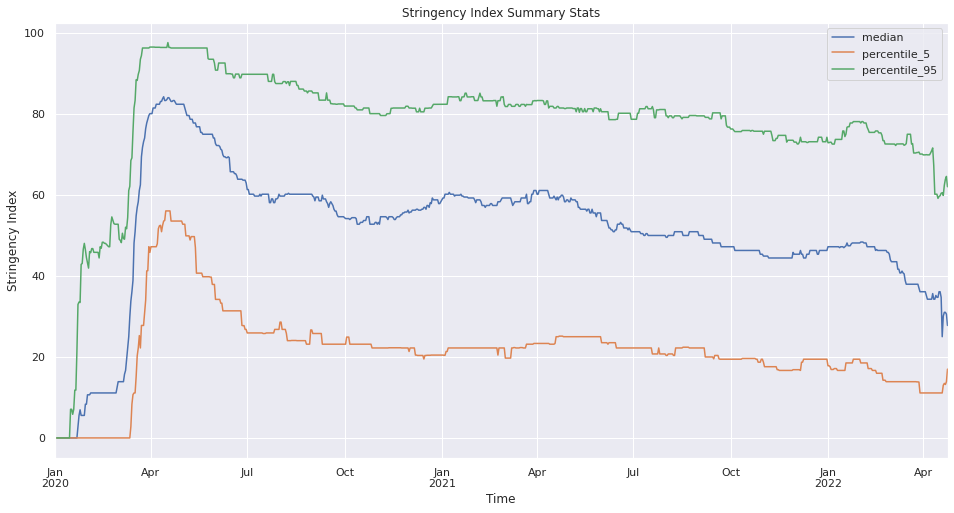

In [7]:
plot_summary(stringency_df, title='Stringency Index Summary Stats', metric='stringency_index', remove_mean=True)

---

### Containment/Health

In [8]:
containment_health_df = pd.read_csv('data/stringency/covid-containment-and-health-index.csv')
containment_health_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)

In [9]:
containment_health_df['date'] = pd.to_datetime(containment_health_df['date'])

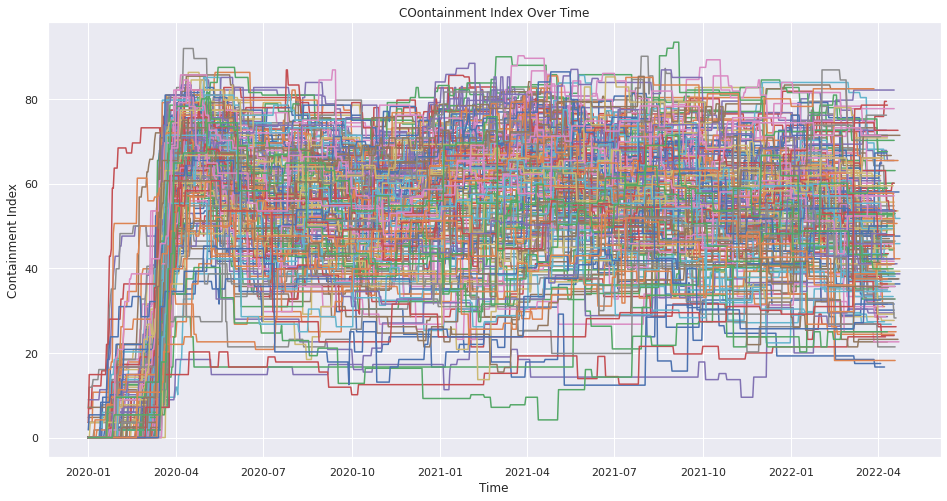

In [10]:
plot_full(countries, containment_health_df, title='COontainment Index Over Time', metric='containment_index')

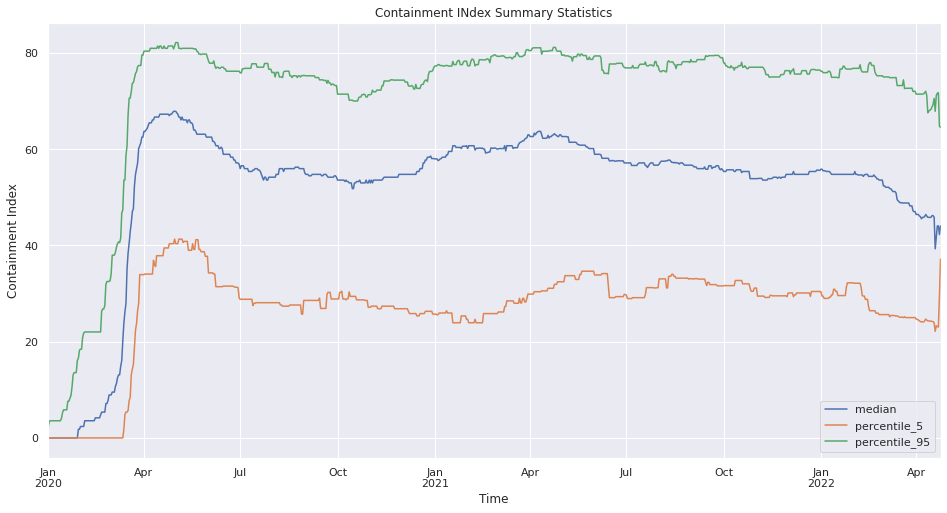

In [11]:
plot_summary(containment_health_df, title='Containment INdex Summary Statistics', metric='containment_index', remove_mean=True)

### Deaths
Deaths can be an intensity metric

In [12]:
covid_history_df = pd.read_csv('data/general/owid-covid-data.csv')
covid_history_df.rename(columns={
    "location":"country",
    "iso_code":"code"},
    inplace=True)

owid_aggregations_df = covid_history_df[covid_history_df['code'].isin(special_owid_codes)]
owid_aggregations_df.rename(columns={
    "country":"category"},
    inplace=True)

covid_history_df = covid_history_df[~covid_history_df['code'].isin(special_owid_codes)].sort_values(by=['code', 'date'])

In [13]:
income_levels = [level for level in owid_aggregations_df["category"].unique() if level.endswith("income")]
income_levels

['High income', 'Low income', 'Lower middle income', 'Upper middle income']

In [14]:
# remove rows for any country before it makes a contribution to the data
def remove_rows_before_contributions():
    for code in covid_history_df.code.unique():
        _df = covid_history_df[covid_history_df['code'] == code]
        for row in _df.itertuples():
            if (row.new_cases == 0 or row.new_cases is None) and (row.total_cases == 0 or row.total_cases is None):
                covid_history_df.drop(index=row.Index, inplace=True)
                break
        continue
remove_rows_before_contributions()

Deaths per million

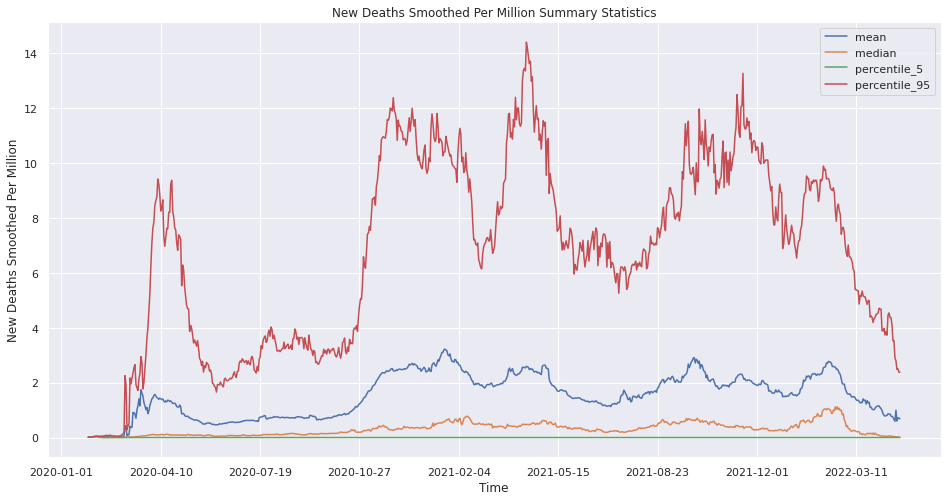

In [15]:
plot_summary(covid_history_df, title='New Deaths Smoothed Per Million Summary Statistics', metric="new_deaths_smoothed_per_million")

Mortality

In [16]:
# Align the zeros of the two y-axes
# Adapted from: https://stackoverflow.com/a/54355867/6712832
def align_yaxis(ax1, ax2):
    y_lims = np.array([ax.get_ylim() for ax in [ax1, ax2]])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim1, new_lim2 = y_new_lims_normalized * y_mags
    ax1.set_ylim(new_lim1)
    ax2.set_ylim(new_lim2)

(0.0, 75.0)

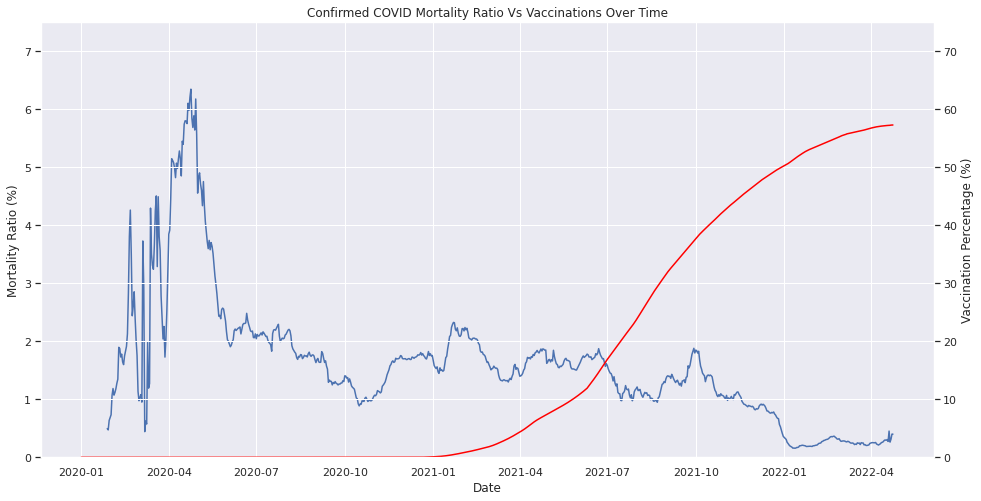

In [17]:
mortality_df = covid_history_df.groupby('date').agg('sum').reset_index()
mortality_df['date'] = pd.to_datetime(mortality_df['date'])
fig, ax = plt.subplots()

ax.plot(mortality_df['date'], 100*mortality_df['new_deaths_smoothed_per_million']/mortality_df['new_cases_smoothed_per_million'], label='Mortality Ratio')
ax.set_title('Confirmed COVID Mortality Ratio Vs Vaccinations Over Time')
ax.set_ylabel('Mortality Ratio (%)')
ax.set_xlabel('Date')

ax_twin = ax.twinx()
ax_twin.plot(mortality_df['date'], 100*np.cumsum(mortality_df['new_people_vaccinated_smoothed'])/mortality_df['population'], color='red', label='Vaccination Percentage')

ax_twin.set_ylabel('Vaccination Percentage (%)')
# align_yaxis(ax, ax_twin)
ax.set_ylim([0, 7.5])
ax_twin.set_ylim([0, 75])

# Standard error for mortality ratio. Formula here: https://www.statology.org/standard-error-of-proportion/


### Mobility

In [18]:
mobility_df = pd.read_csv("data/mobility/changes-visitors-covid.csv")
mobility_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)
merged_df = pd.merge(covid_history_df, mobility_df, how="outer", on=["country", "code", "date"])

debt_relief_df = pd.read_csv("data/income_relief/debt-relief-covid.csv")
debt_relief_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)
merged_df = pd.merge(merged_df, debt_relief_df, how="outer", on=["country", "code", "date"])

income_support_df = pd.read_csv("data/income_relief/income-support-covid.csv")
income_support_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)
merged_df = pd.merge(merged_df, income_support_df, how="outer", on=["country", "code", "date"])

In [19]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184145 entries, 0 to 184144
Data columns (total 75 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   code                                        184145 non-null  object 
 1   continent                                   170540 non-null  object 
 2   country                                     184145 non-null  object 
 3   date                                        184145 non-null  object 
 4   total_cases                                 164094 non-null  float64
 5   new_cases                                   163862 non-null  float64
 6   new_cases_smoothed                          162758 non-null  float64
 7   total_deaths                                146076 non-null  float64
 8   new_deaths                                  145874 non-null  float64
 9   new_deaths_smoothed                         144792 non-null  float64
 

Optimizing lag

In [20]:
_sub_df  = merged_df[merged_df['date'] <= '2020-12-31'] # test appropriate compliance lag is most useful in 2020 
greatest_abs_corr = 0
for lag in range(0,90):
    _corr = _sub_df['stringency_index'].corr(_sub_df['residential'].shift(lag))
    # print(_corr)
    if abs(_corr) > greatest_abs_corr:
        greatest_abs_corr = abs(_corr)
        print(f"{lag} days lag: {_corr}")

0 days lag: 0.6825812691310847


In [21]:
# Optimizing lag on a country by country basis would look like this:
# greatest_abs_corr = 0
# for lag in range(0,90):
#     _corr = merged_df[merged_df['country'] == 'United Kingdom']['stringency_index'].corr(merged_df[merged_df['country'] == 'United Kingdom']['residential'].shift(lag))
#     # print(_corr)
#     if abs(_corr) > greatest_abs_corr:
#         greatest_abs_corr = abs(_corr)
#         print(f"{lag} days lag: {_corr}")

---

Modelling utility functions

In [22]:
def feature_engineering(df, y_feature, keep_country=False, drop_features=None, 
                        add_logs=True, add_squares=True, cross_features=False, y_lag=0, 
                        log_exclude=['income_support', 'debt_relief'], 
                        square_exclude=['income_support', 'debt_relief']):
    if drop_features is not None:
        df = df.drop(columns=drop_features)
    df_copy = df.copy()

    df_copy[y_feature] = df_copy[y_feature].shift(-y_lag)

    y = df_copy[y_feature]
    X = df_copy.drop([y_feature], axis=1)
    X_columns = X.columns[1:]

    for col in X_columns:
        if is_numeric_dtype(X[col]):
            if add_logs:
                if col not in log_exclude:
                    X[f"{col}_log"] = np.log(X[col])
            if add_squares:
                if col not in square_exclude:
                    X[f"{col}_squared"] = X[col]**2

    # Cross-feature combinations
    if cross_features:
        for combo in combinations(X.columns[1:], 2):
            X[f"{combo[0]}_{combo[1]}"] = X[combo[0]] * X[combo[1]]

    X['y'] = y
    X.dropna(inplace=True)
    y = X['y']
    X = X.drop(['y'], axis=1)
    if not keep_country:
        X = X.drop(['country'], axis=1)

    return X, y

In [23]:
# https://github.com/AakkashVijayakumar/stepwise-regression/blob/master/stepwise_regression/step_reg.py
def forward_regression(X, y,
                       threshold_in=0.05,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

def backward_regression(X, y,
                           threshold_out=0.05,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

---


### Q1. Headline
* Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
* Mortality ratio (Derived from cases and deaths) - how deadly is it?
* Stringency over time  - how are governments responding?
* Mobility over time - how are people reacting?


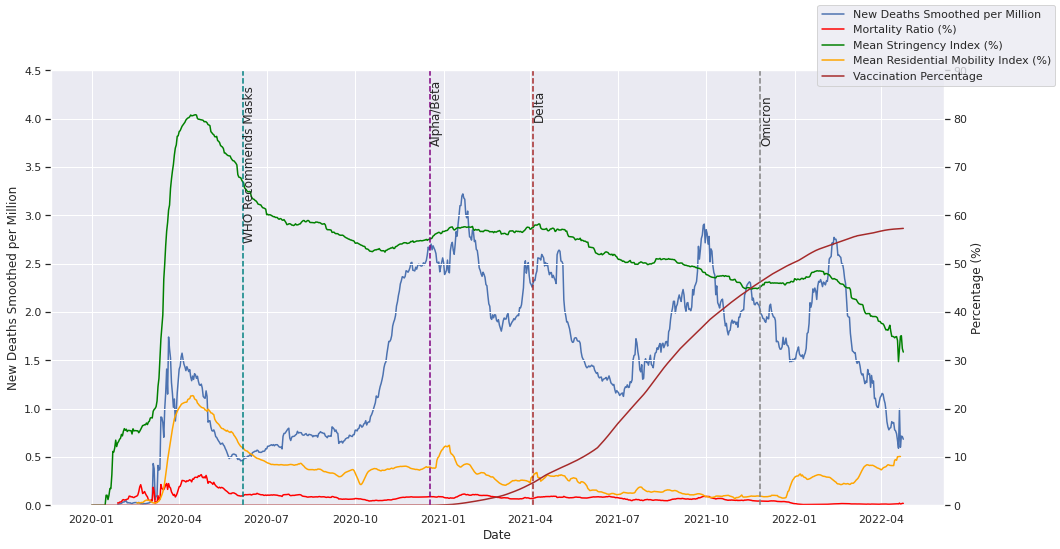

In [24]:
date_sum_df = merged_df.groupby('date').agg('sum').reset_index()
date_mean_df = merged_df.groupby('date').agg('mean').reset_index()

date_sum_df['date'] = pd.to_datetime(date_sum_df['date'])
date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])

date_sum_df['mortality_ratio'] = 100*date_sum_df['new_deaths_smoothed_per_million']/date_sum_df['new_cases_smoothed_per_million']

fig, ax = plt.subplots()

# Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
ax.plot(date_mean_df['date'], date_mean_df['new_deaths_smoothed_per_million'], label='New Deaths Smoothed per Million')
ax.set_ylabel('New Deaths Smoothed per Million')
ax.set_xlabel('Date')

# Mortality ratio (Derived from cases and deaths) - how deadly is it?
ax_twin_percentages = ax.twinx()
ax_twin_percentages.plot(date_sum_df['date'], date_sum_df['mortality_ratio'], label='Mortality Ratio (%)', color='red')
ax_twin_percentages.set_ylabel('Percentage (%)')

# Stringency over time  - how are governments responding?
ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['stringency_index'], label='Mean Stringency Index (%)', color='green')

ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['residential'], label='Mean Residential Mobility Index (%)', color='orange')

ax_twin_percentages.plot(date_sum_df['date'], 100*np.cumsum(date_sum_df['new_people_vaccinated_smoothed'])/date_sum_df['population'], color='brown', label='Vaccination Percentage')

ax.set_ylim(0, 4.5)
ax_twin_percentages.set_ylim(0, 90)

# Variant lines. Dates the variants were declared variants of concern.
# Accroding to: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/
ax_twin_percentages.axvline(x='2020-12-18', linestyle='--', color='purple')
ax_twin_percentages.text('2020-12-18',75,'Alpha/Beta',rotation=90)
ax_twin_percentages.axvline(x='2021-04-04', linestyle='--', color='brown')
ax_twin_percentages.text('2021-04-04',80,'Delta',rotation=90)
ax_twin_percentages.axvline(x='2021-11-26', linestyle='--', color='gray')
ax_twin_percentages.text('2021-11-26',75,'Omicron',rotation=90)
ax_twin_percentages.axvline(x='2020-06-06', linestyle='--', color='teal')
ax_twin_percentages.text('2020-06-06',55,'WHO Recommends Masks',rotation=90)
fig.legend()

Changes in correlation over time

In [25]:
# Global compliance in the pre-vaccine period
temp_df = date_mean_df[date_mean_df['date'] <= '2020-12-31']
temp_df = temp_df[temp_df['date'] >= '2020-04-01']
print(temp_df['residential'].corr(temp_df['stringency_index']))

0.9663217534266699


North America 0.9579382103914885
South America 0.9390197441700987
Asia 0.9439902154039429
Europe 0.9814186532231227
Oceania 0.8974048099822921
Africa 0.9273953462249602


Text(0, 0.5, 'Correlation of Residential Mobility and Stringency Index')

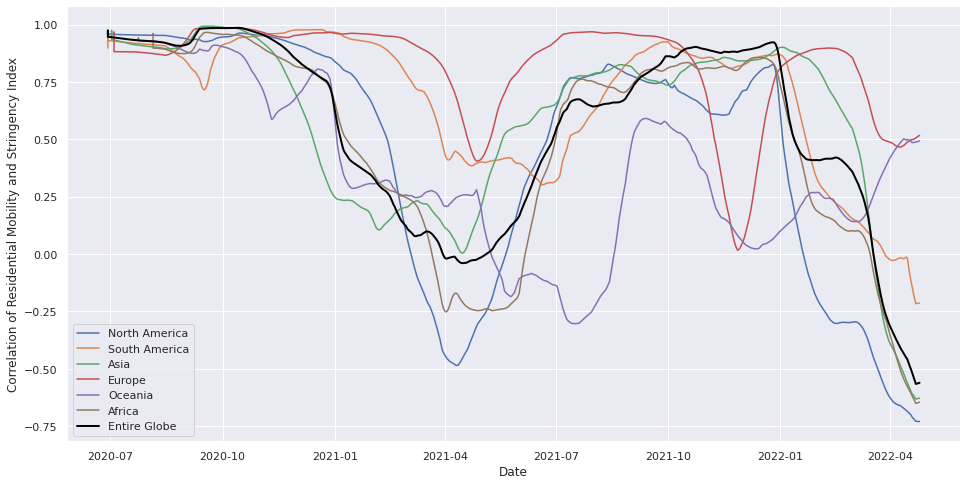

In [26]:
df_for_windows = merged_df[['date', 'continent', 'residential', 'stringency_index']]
df_for_windows['date'] = pd.to_datetime(df_for_windows['date'])

rolling_window = 180 # Averaging window of 6 months
panic_window = 90 # The first 3 months of data from Jan to March involve a lot of panic, this can throw our analysis off.

df_for_windows = df_for_windows.groupby(['date', 'continent']).agg('mean').reset_index()

for continent in df_for_windows['continent'].unique():
    residential_corr = []
    end_dates = []
    if continent not in ['0', 0]:
        print(continent, end=' ') # a weird zero pops up during the aggregation... probably due to aggregations done at OWID level
        for window in df_for_windows[df_for_windows['continent']==continent].rolling(window=rolling_window):
            # if len(window) > 0:
            residential_corr.append(window[['residential','stringency_index']].corr()['stringency_index'][0])
            end_dates.append(window['date'].iloc[0] + timedelta(days=rolling_window))
        plt.plot(end_dates[panic_window:], residential_corr[panic_window:], label=continent)

        continent_df = df_for_windows[df_for_windows['continent']==continent]
        continent_df = continent_df[continent_df['date'] <= '2020-12-31']
        continent_df = continent_df[continent_df['date'] >= '2020-04-01']
        # plt.scatter(continent_df['residential'], continent_df['stringency_index'])
        # a, b = np.polyfit(continent_df['residential'], continent_df['stringency_index'], 1)
        
        # plt.plot(continent_df['residential'], a*continent_df['residential']+b, color='red')
        # plt.show()
        print(continent_df['residential'].corr(continent_df['stringency_index']))
        
residential_corr = []
end_dates = []
df_for_windows = df_for_windows[['date', 'residential', 'stringency_index']].groupby(['date']).agg('mean').reset_index()
for window in df_for_windows.rolling(window=rolling_window):
    # if len(window) > 0:
    residential_corr.append(window[['residential','stringency_index']].corr()['stringency_index'][0])
    end_dates.append(list(window['date'])[0] + timedelta(days=rolling_window))
plt.plot(end_dates[panic_window:], residential_corr[panic_window:], label="Entire Globe", color="black", linewidth=2)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Correlation of Residential Mobility and Stringency Index")

### Q2. Effectiveness of disaggregated measures:
a. Masks  
b. Vaccinations  
c. Lockdowns  
d. School closure  

In [27]:
face_coverings_df = pd.read_csv('data/stringency/face_coverings/face-covering-policies-covid.csv')[['Entity', 'Day', 'facial_coverings']]
face_coverings_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)

merged_df = pd.merge(merged_df, face_coverings_df, on=['country', 'date'], how='left')

In [28]:
lockdowns_df = pd.read_csv('data/stringency/lockdowns/stay-at-home-covid.csv')[['Entity', 'Day', 'stay_home_requirements']]
lockdowns_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)

merged_df = pd.merge(merged_df, lockdowns_df, on=['country', 'date'], how='left')

In [29]:
school_closure_df = pd.read_csv('data/stringency/school_closure/school-closures-covid.csv')[['Entity', 'Day', 'school_closures']]
school_closure_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)

merged_df = pd.merge(merged_df, school_closure_df, on=['country', 'date'], how='left')

In [30]:
workplace_closure_df = pd.read_csv('data/stringency/workplace_closure/workplace-closures-covid.csv')[['Entity', 'Day', 'workplace_closures']]
workplace_closure_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)

merged_df = pd.merge(merged_df, workplace_closure_df, on=['country', 'date'], how='left')

In [31]:
# Policy Regressions Against Cases
policy_cases_df = merged_df[['date', 'country']+list(merged_df.columns[-4:])+['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 'residential', 'new_people_vaccinated_smoothed', 'population']]

In [32]:
# Pull in stringency sub-indices
# Public event stringency
event_stringency_df = pd.read_csv('data/stringency/gatherings_and_events/public-events-covid.csv')[['Entity', 'Day', 'cancel_public_events']]
event_stringency_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
policy_cases_df = policy_cases_df.merge(event_stringency_df, on=['country', 'date'], how='left')

# gathering restrictions
gethering_stringency_df = pd.read_csv('data/stringency/gatherings_and_events/public-gathering-rules-covid.csv')[['Entity', 'Day', 'restriction_gatherings']]
gethering_stringency_df.rename(columns={
    "Entity":"country",
    "Day":"date",
    "restriction_gatherings":"gathering_restrictions"},
    inplace=True)
policy_cases_df = policy_cases_df.merge(gethering_stringency_df, on=['country', 'date'], how='left')

# public info campaigns
info_campaigns_df = pd.read_csv('data/stringency/information/public-campaigns-covid.csv')[['Entity', 'Day', 'public_information_campaigns']]
info_campaigns_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
policy_cases_df = policy_cases_df.merge(info_campaigns_df, on=['country', 'date'], how='left')

# internal movement restrictions
internal_movement_df = pd.read_csv('data/stringency/movement_restrictions/internal-movement-covid.csv')[['Entity', 'Day', 'restrictions_internal_movements']]
internal_movement_df.rename(columns={
    "Entity":"country",
    "Day":"date",
    "restrictions_internal_movements":"internal_movement_restrictions"},
    inplace=True)
policy_cases_df = policy_cases_df.merge(internal_movement_df, on=['country', 'date'], how='left')

# international travel restrictions
international_travel_df = pd.read_csv('data/stringency/movement_restrictions/international-travel-covid.csv')[['Entity', 'Day', 'international_travel_controls']]
international_travel_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
policy_cases_df = policy_cases_df.merge(international_travel_df, on=['country', 'date'], how='left')

# public transport restrictions
public_transport_df = pd.read_csv('data/stringency/movement_restrictions/public-transport-covid.csv')[['Entity', 'Day', 'close_public_transport']]
public_transport_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
policy_cases_df = policy_cases_df.merge(public_transport_df, on=['country', 'date'], how='left')

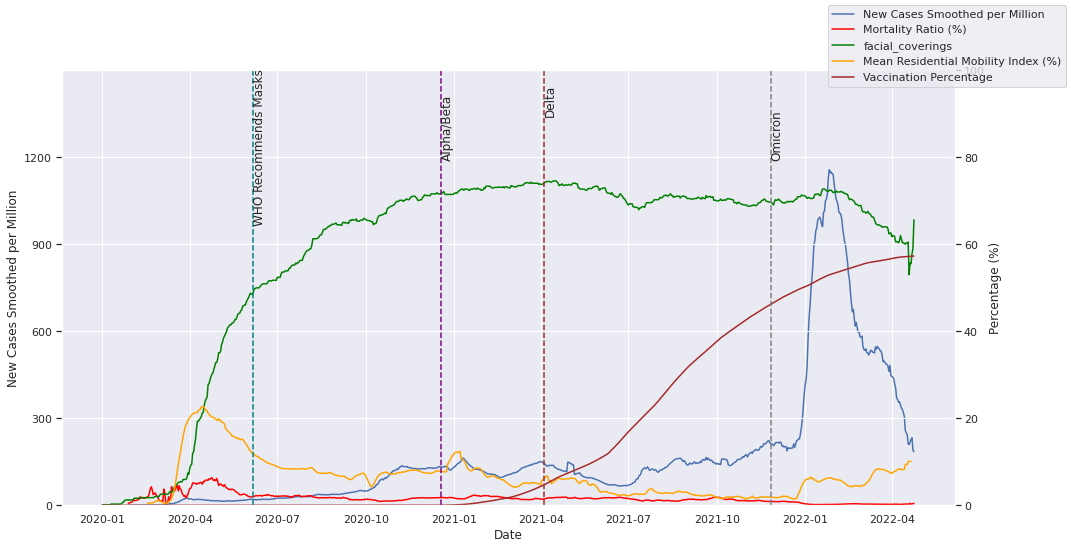

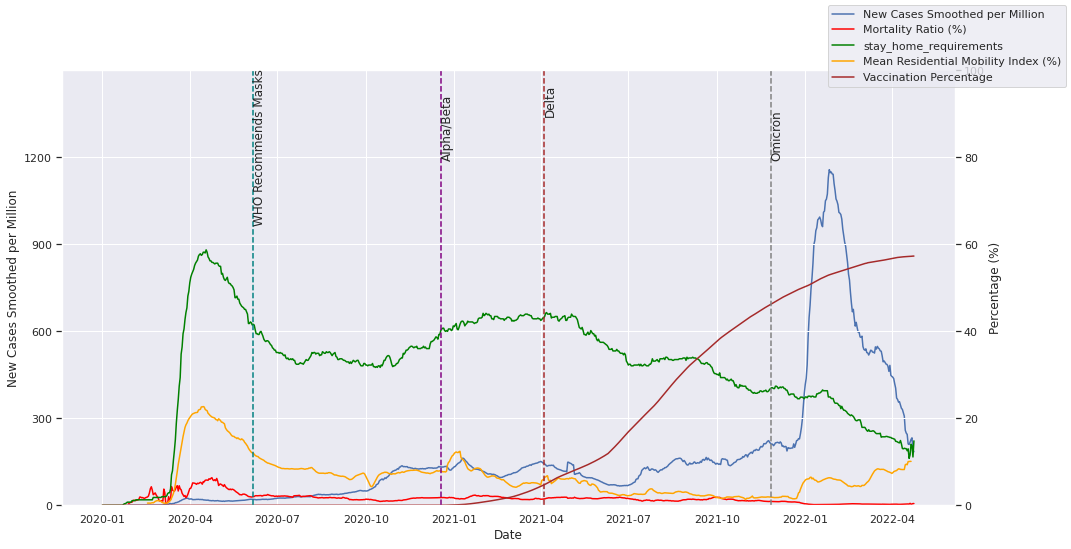

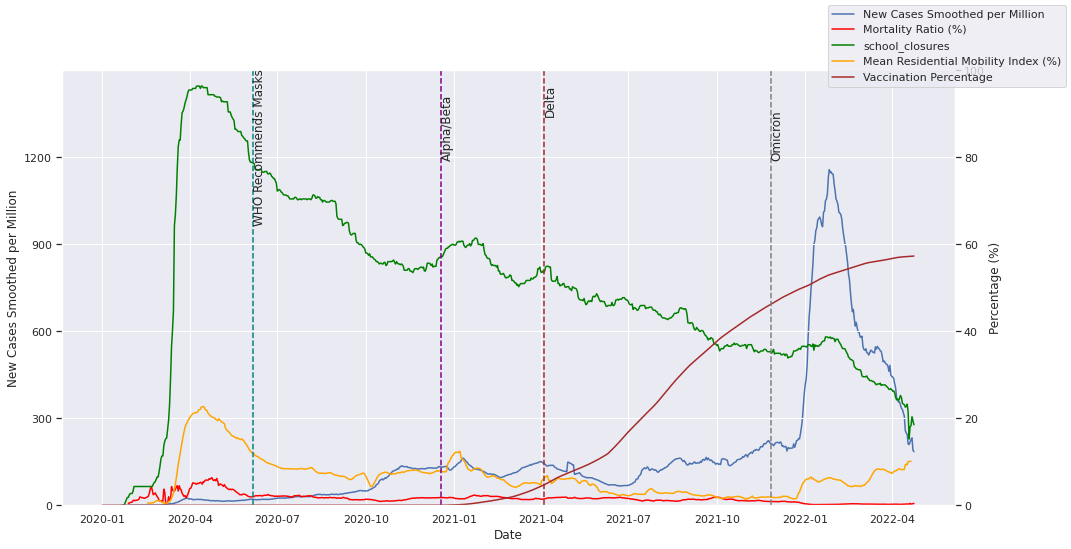

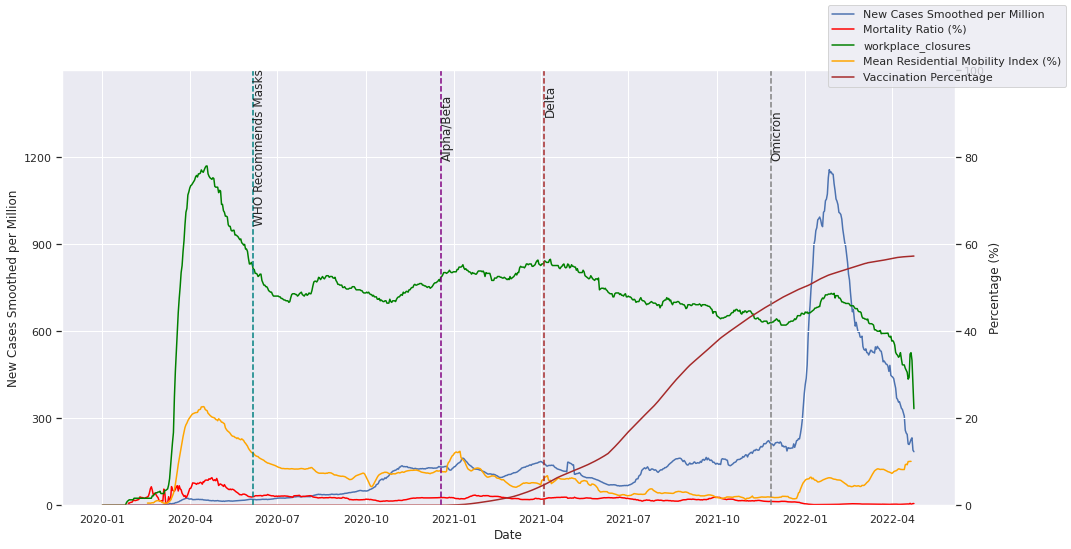

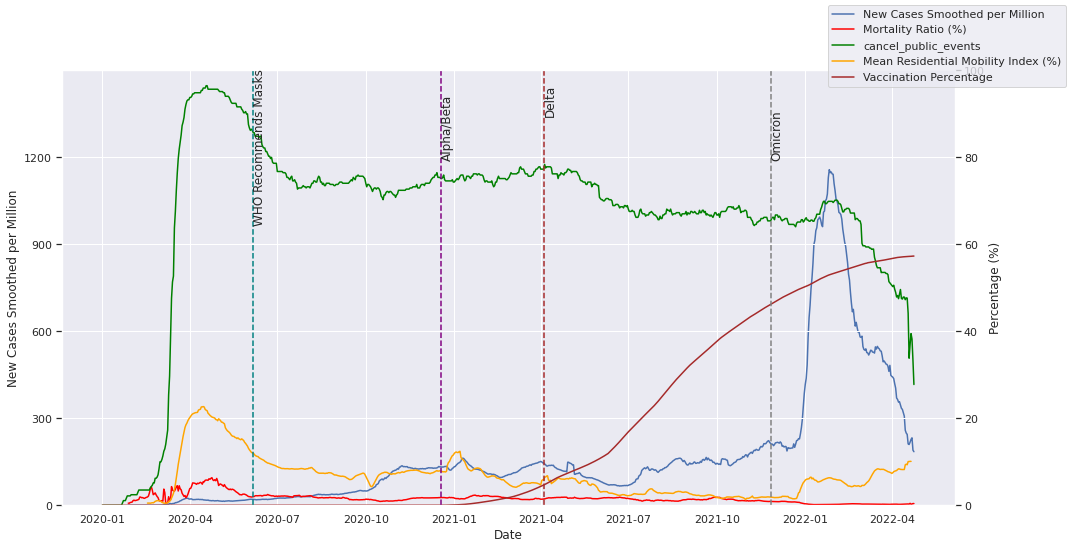

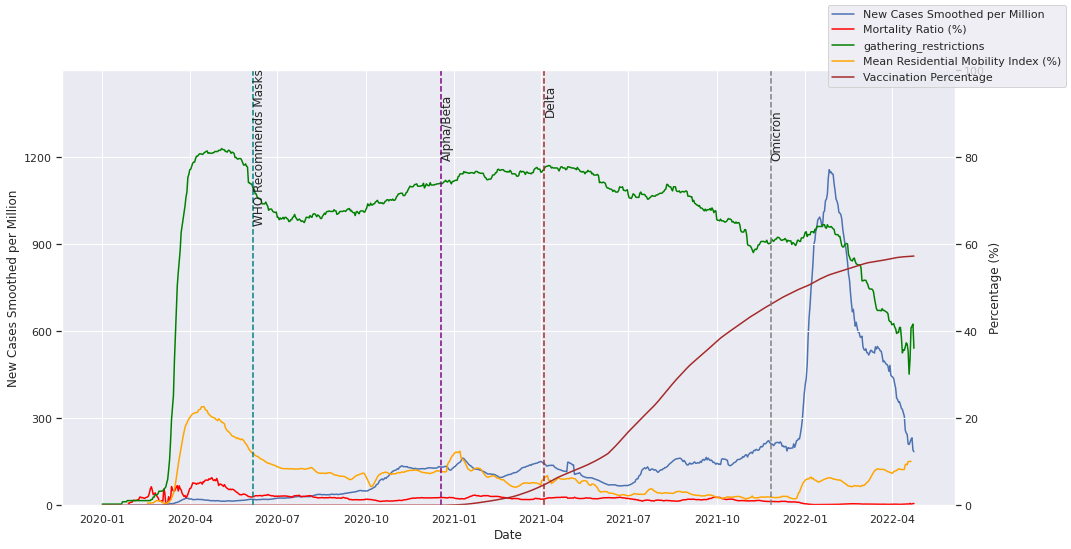

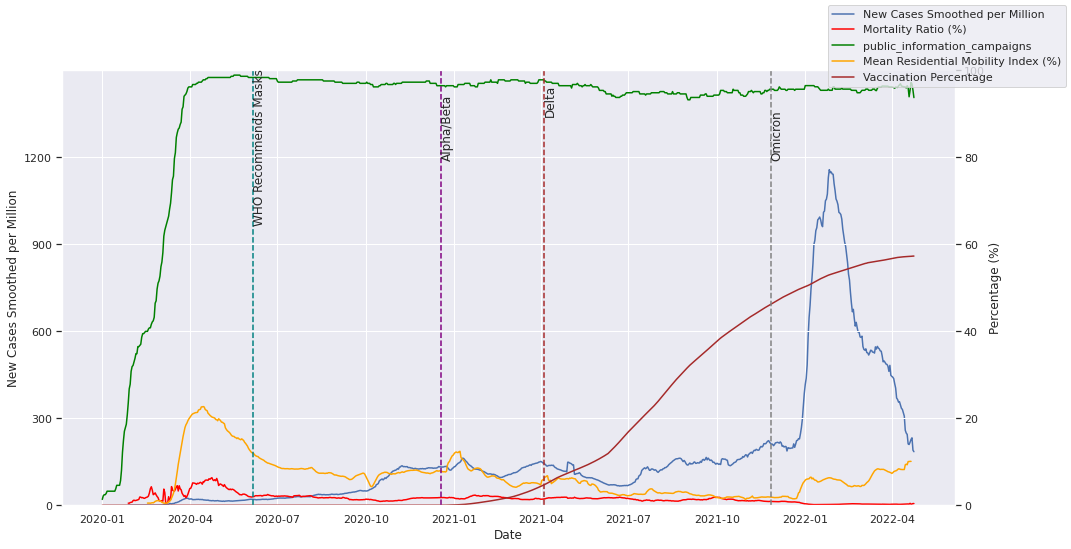

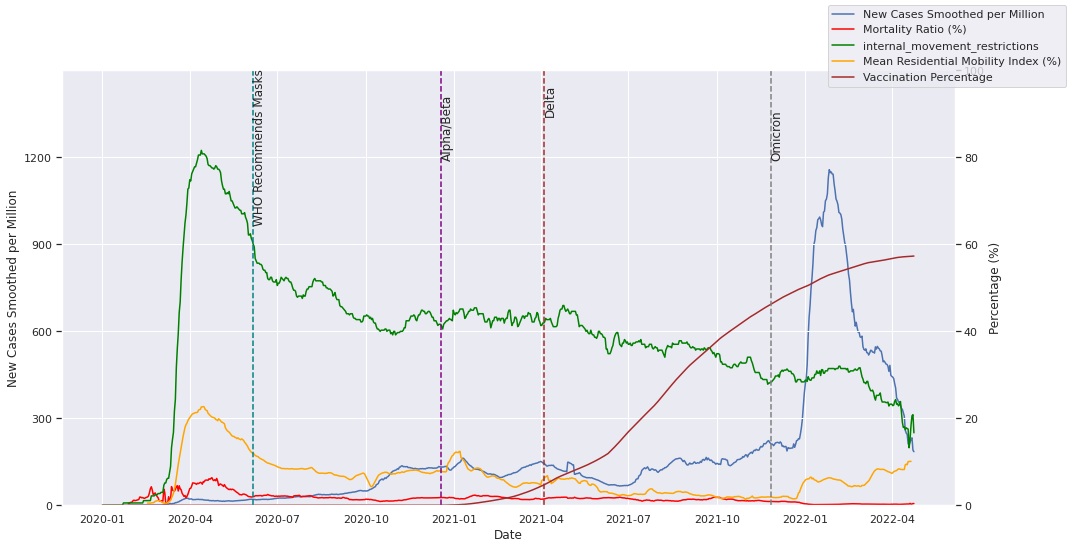

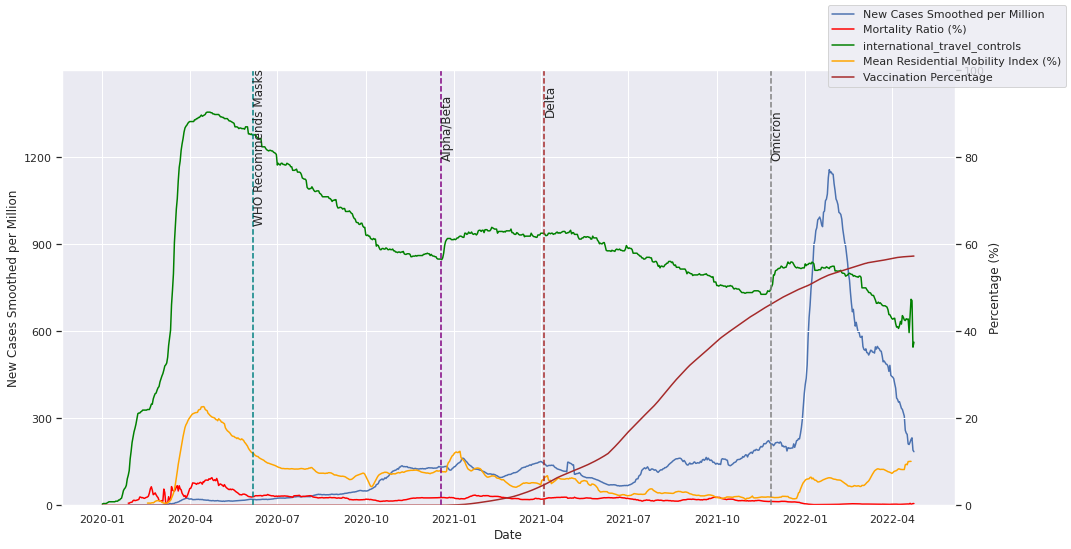

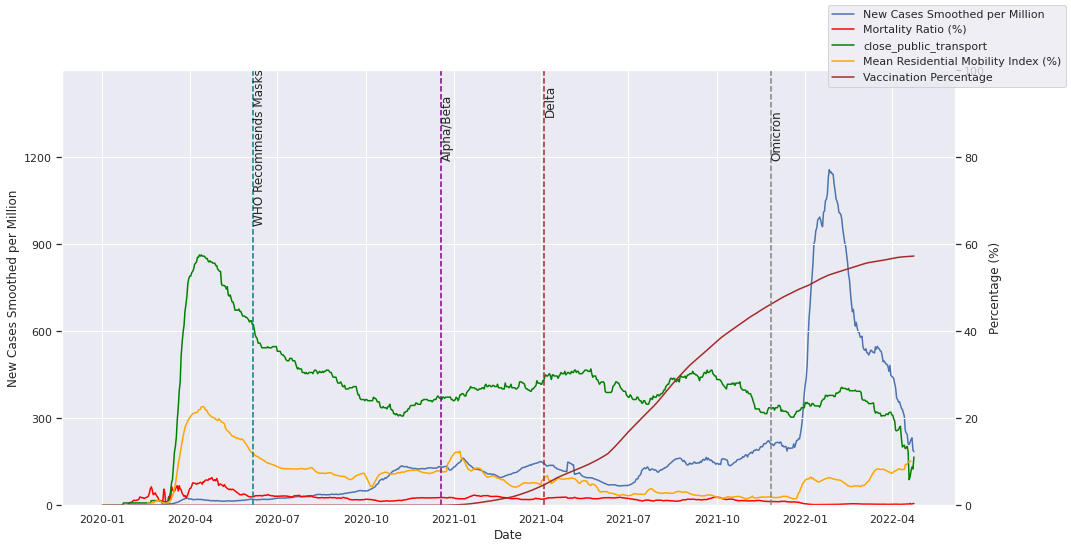

In [33]:
# feature_labels = {
#     'facial_coverings': 'Facial Coverings (Mask Usage)',
#     'stay_home_requirements': 'Stay At Home Requirements',
#     'school_closures': 'School Closures',
#     'workplace_closures': 'Workplace Closures'
# }
for feature in policy_cases_df.columns:
    if feature in ['date', 'country', 'new_cases_smoothed_per_million',
        'new_deaths_smoothed_per_million', 'residential', 
        'new_people_vaccinated_smoothed', 'population']\
        or "cases" in feature:
        continue
    policy_cases_df[feature] = 100 * policy_cases_df[feature]/max(policy_cases_df[feature])
    # Sum features need to be summed in aggregation
    # Others need to be averaged in aggregation
    date_sum_df = policy_cases_df.groupby('date').agg('sum').reset_index()
    date_mean_df = policy_cases_df.groupby('date').agg('mean').reset_index()

    date_sum_df['date'] = pd.to_datetime(date_sum_df['date'])
    date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])

    fig, ax = plt.subplots()

    # Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
    ax.plot(date_mean_df['date'], date_mean_df['new_cases_smoothed_per_million'], label='New Cases Smoothed per Million')
    ax.set_ylabel('New Cases Smoothed per Million')
    ax.set_xlabel('Date')

    # Mortality ratio (Derived from cases and deaths) - how deadly is it?
    ax_twin_percentages = ax.twinx()
    ax_twin_percentages.plot(date_sum_df['date'], 100*date_sum_df['new_deaths_smoothed_per_million']/date_sum_df['new_cases_smoothed_per_million'], label='Mortality Ratio (%)', color='red')
    ax_twin_percentages.set_ylabel('Percentage (%)')

    # Stringency over time  - how are governments responding?
    ax_twin_percentages.plot(date_mean_df['date'], date_mean_df[feature], label=feature, color='green')

    ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['residential'], label='Mean Residential Mobility Index (%)', color='orange')

    ax_twin_percentages.plot(date_sum_df['date'], 100*np.cumsum(date_sum_df['new_people_vaccinated_smoothed'])/date_sum_df['population'], color='brown', label='Vaccination Percentage')

    ax.set_ylim(0, 1500)
    ax.yaxis.set_ticks(np.arange(0, 1500, 300))
    ax_twin_percentages.set_ylim(0, 100)

    # Variant lines. Dates the variants were declared variants of concern.
    # Accroding to: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/
    ax_twin_percentages.axvline(x='2020-12-18', linestyle='--', color='purple')
    ax_twin_percentages.text('2020-12-18',80,'Alpha/Beta',rotation=90)
    ax_twin_percentages.axvline(x='2021-04-04', linestyle='--', color='brown')
    ax_twin_percentages.text('2021-04-04',90,'Delta',rotation=90)
    ax_twin_percentages.axvline(x='2021-11-26', linestyle='--', color='gray')
    ax_twin_percentages.text('2021-11-26',80,'Omicron',rotation=90)
    ax_twin_percentages.axvline(x='2020-06-06', linestyle='--', color='teal')
    ax_twin_percentages.text('2020-06-06',65,'WHO Recommends Masks',rotation=90)

    fig.legend()
    plt.show()

In [34]:
# policy_cases_df.columns

In [35]:
# get changes in cases as an alternate y variable
policy_cases_df['date'] = pd.to_datetime(policy_cases_df['date'])
policy_cases_df["cases_changes"] = policy_cases_df.groupby('country')['new_cases_smoothed_per_million'].diff()

# implement lags
for lag in (7,14,21,28):
    policy_cases_df[f"cases_lag_{lag}"] = policy_cases_df.groupby('country')['new_cases_smoothed_per_million'].shift(-lag)

In [36]:
policy_cases_df = policy_cases_df[policy_cases_df['date'] <= '2020-12-31']
policy_cases_df = policy_cases_df[policy_cases_df['date'] >= '2020-04-01']

<AxesSubplot:>

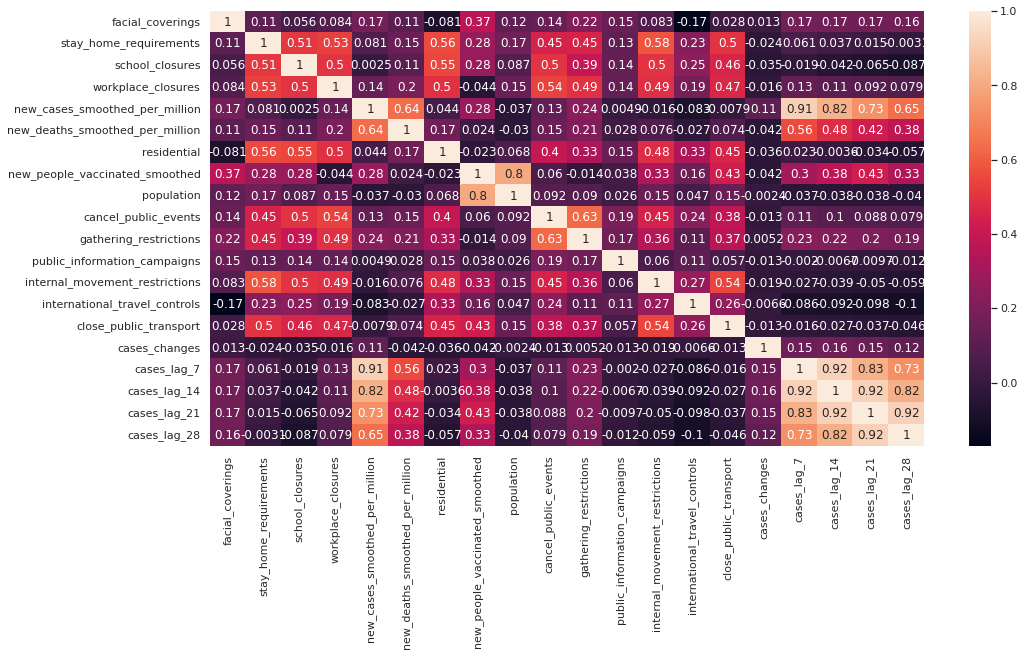

In [37]:
# correlations
sns.heatmap(policy_cases_df[policy_cases_df.columns[2:]].corr(), annot=True)

In [38]:
def insample_rsquared(X, y):
    lr = LinearRegression()
    lr.fit(X, y)
    lr_preds = lr.predict(X)
    return r2_score(y, lr_preds)

In [39]:
X, y = feature_engineering(policy_cases_df, 'new_cases_smoothed_per_million', 
                            drop_features=['cases_changes', 'date']+[f"cases_lag_{lag}" for lag in (7,14,21,28)],
                            add_logs=False, add_squares=False)

Baseline regression

In [40]:
# check for infs
X.index[np.isinf(X).any(1)]

Int64Index([], dtype='int64')

In [41]:
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     27.63
Date:                Wed, 04 May 2022   Prob (F-statistic):           2.37e-40
Time:                        01:32:20   Log-Likelihood:                -1426.7
No. Observations:                 228   AIC:                             2883.
Df Residuals:                     213   BIC:                             2935.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1345.1640    225.444      5.967      0.000     900.777    1789.551
facial_coverings                   -2.3936      0.828     -2.890      0.004      -4.026      -0.761
stay_home_requirements             -0.3239      0.595     -0.545      0.586      -1.496       0.848
school_closures                     1.7001      0.486      3.500      0.001       0.743       2.658
workplace_closures                 -0.2051      0.648     -0.317      0.752      -1.482       1.072
new_deaths_smoothed_per_million    28.6565      4.485      6.389      0.000      19.815      37.498
residential                        -8.3501      3.287     -2.540      0.012     -14.830      -1.870
new_people_vaccinated_smoothed      0.0008      0.000      3.310      0.001       0.000       0.001
population                       3.102e-07   2.16e-07      1.437      0.152   -1.15e-07    7.36e-07
cancel_public_events               -2.8582      1.061     -2.693      0.008      -4.950      -0.766
gathering_restrictions              0.3650      1.223      0.298      0.766      -2.046       2.776
public_information_campaigns       -8.9540      1.705     -5.251      0.000     -12.315      -5.593
internal_movement_restrictions     -1.2310      0.342     -3.600      0.000      -1.905      -0.557
international_travel_controls       2.3401      0.507      4.613      0.000       1.340       3.340
close_public_transport              0.6148      0.557      1.103      0.271      -0.484       1.713
==============================================================================
Omnibus:                        7.555   Durbin-Watson:                   0.423
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                8.692
Skew:                           0.293   Prob(JB):                       0.0130
Kurtosis:                       3.755   Cond. No.                     2.57e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
forward_included = forward_regression(X, y)
backward_included = backward_regression(X, y)

In [43]:
print(forward_included)
sm.OLS(y, sm.add_constant(X[forward_included])).fit().summary()

['new_deaths_smoothed_per_million', 'new_people_vaccinated_smoothed', 'facial_coverings', 'public_information_campaigns', 'international_travel_controls', 'internal_movement_restrictions', 'residential', 'school_closures', 'cancel_public_events']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     42.67
Date:                Wed, 04 May 2022   Prob (F-statistic):           2.16e-43
Time:                        01:32:21   Log-Likelihood:                -1428.9
No. Observations:                 228   AIC:                             2878.
Df Residuals:                     218   BIC:                             2912.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1251.8471    191.678      6.531      0.000     874.067    1629.627
new_deaths_smoothed_per_million    30.7410      3.883      7.917      0.000      23.088      38.394
new_people_vaccinated_smoothed      0.0011      0.000      7.535      0.000       0.001       0.001
facial_coverings                   -2.2553      0.715     -3.155      0.002      -3.664      -0.846
public_information_campaigns       -7.9637      1.571     -5.069      0.000     -11.060      -4.867
international_travel_controls       2.1726      0.483      4.501      0.000       1.221       3.124
internal_movement_restrictions     -1.0832      0.257     -4.207      0.000      -1.591      -0.576
residential                        -9.8114      2.796     -3.509      0.001     -15.322      -4.301
school_closures                     1.7430      0.450      3.870      0.000       0.855       2.631
cancel_public_events               -2.7004      0.966     -2.795      0.006      -4.605      -0.796
==============================================================================
Omnibus:                        8.494   Durbin-Watson:                   0.393
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                9.209
Skew:                           0.356   Prob(JB):                       0.0100
Kurtosis:                       3.679   Cond. No.                     1.60e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
print(backward_included)
sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

['facial_coverings', 'school_closures', 'new_deaths_smoothed_per_million', 'residential', 'new_people_vaccinated_smoothed', 'cancel_public_events', 'public_information_campaigns', 'internal_movement_restrictions', 'international_travel_controls']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     42.67
Date:                Wed, 04 May 2022   Prob (F-statistic):           2.16e-43
Time:                        01:32:22   Log-Likelihood:                -1428.9
No. Observations:                 228   AIC:                             2878.
Df Residuals:                     218   BIC:                             2912.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1251.8471    191.678      6.531      0.000     874.067    1629.627
facial_coverings                   -2.2553      0.715     -3.155      0.002      -3.664      -0.846
school_closures                     1.7430      0.450      3.870      0.000       0.855       2.631
new_deaths_smoothed_per_million    30.7410      3.883      7.917      0.000      23.088      38.394
residential                        -9.8114      2.796     -3.509      0.001     -15.322      -4.301
new_people_vaccinated_smoothed      0.0011      0.000      7.535      0.000       0.001       0.001
cancel_public_events               -2.7004      0.966     -2.795      0.006      -4.605      -0.796
public_information_campaigns       -7.9637      1.571     -5.069      0.000     -11.060      -4.867
internal_movement_restrictions     -1.0832      0.257     -4.207      0.000      -1.591      -0.576
international_travel_controls       2.1726      0.483      4.501      0.000       1.221       3.124
==============================================================================
Omnibus:                        8.494   Durbin-Watson:                   0.393
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                9.209
Skew:                           0.356   Prob(JB):                       0.0100
Kurtosis:                       3.679   Cond. No.                     1.60e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Continent-wise regression

In [45]:
continent_dict = {}
for name, group in merged_df.groupby('continent'):
    continent_dict[name] = set(group['country'])

    X, y = feature_engineering(policy_cases_df[policy_cases_df['country'].isin(continent_dict[name])], 
                                'new_cases_smoothed_per_million',
                                drop_features=['cases_changes', 'date']+[f"cases_lag_{lag}" for lag in (7,14,21,28)],
                                add_logs=False, add_squares=False)
    print(f"{name} ({len(continent_dict[name])} countries)",":", "In-sample r-squared:", insample_rsquared(X, y))
    backward_included = backward_regression(X, y)
    print(sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary())
    print(X[backward_included].std())
    print("-"*20, "\n")

ValueError: Found array with 0 sample(s) (shape=(0, 14)) while a minimum of 1 is required.

With lags

1 Week

In [ ]:
X, y = feature_engineering(policy_cases_df, "cases_lag_7", 
                            drop_features=['new_cases_smoothed_per_million', 'cases_changes', 'date']+[f"cases_lag_{lag}" for lag in (14,21,28)],
                            add_logs=False, add_squares=False)
insample_rsquared(X, y)

0.10465955091304746

In [ ]:
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     568.6
Date:                Wed, 04 May 2022   Prob (F-statistic):               0.00
Time:                        00:19:58   Log-Likelihood:            -3.0486e+05
No. Observations:               48652   AIC:                         6.097e+05
Df Residuals:                   48641   BIC:                         6.098e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             51.9795      5.159     10.076      0.000      41.868      62.091
facial_coverings                   0.5222      0.019     27.972      0.000       0.486       0.559
stay_home_requirements             0.1707      0.027      6.376      0.000       0.118       0.223
school_closures                   -0.3387      0.024    -14.038      0.000      -0.386      -0.291
workplace_closures                 0.5368      0.026     20.465      0.000       0.485       0.588
cancel_public_events               4.2454      1.257      3.378      0.001       1.782       6.709
gathering_restrictions            23.6553      0.606     39.004      0.000      22.467      24.844
public_information_campaigns     -32.7169      2.673    -12.239      0.000     -37.956     -27.478
internal_movement_restrictions   -17.3382      0.907    -19.113      0.000     -19.116     -15.560
international_travel_controls     -7.2060      0.597    -12.063      0.000      -8.377      -6.035
close_public_transport           -10.9284      0.993    -11.002      0.000     -12.875      -8.982
==============================================================================
Omnibus:                    39814.368   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           989789.549
Skew:                           3.904   Prob(JB):                         0.00
Kurtosis:                      23.671   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
continent_dict = {}
for name, group in merged_df.groupby('continent'):
    continent_dict[name] = set(group['country'])

    X, y = feature_engineering(policy_cases_df[policy_cases_df['country'].isin(continent_dict[name])], 
                                "cases_lag_7", 
                                drop_features=['new_cases_smoothed_per_million', 'cases_changes', 'date']+[f"cases_lag_{lag}" for lag in (14,21,28)],
                                add_logs=False, add_squares=False)
    print(f"{name} ({len(continent_dict[name])} countries)",":", "In-sample r-squared:", insample_rsquared(X, y))
    backward_included = backward_regression(X, y)
    print(sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary())
    print(X[backward_included].std())
    print("-"*20, "\n")

Africa (56 countries) : In-sample r-squared: 0.06949756184033329
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     113.4
Date:                Wed, 04 May 2022   Prob (F-statistic):          4.37e-206
Time:                        00:19:59   Log-Likelihood:                -64052.
No. Observations:               13695   AIC:                         1.281e+05
Df Residuals:                   13685   BIC:                         1.282e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

2 Weeks

In [ ]:
X, y = feature_engineering(policy_cases_df, "cases_lag_14", 
                            drop_features=['new_cases_smoothed_per_million', 'cases_changes', 'date']+[f"cases_lag_{lag}" for lag in (7,21,28)],
                            add_logs=False, add_squares=False)
insample_rsquared(X, y)

0.10079912429627125

In [ ]:
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     545.3
Date:                Wed, 04 May 2022   Prob (F-statistic):               0.00
Time:                        00:20:01   Log-Likelihood:            -3.0708e+05
No. Observations:               48656   AIC:                         6.142e+05
Df Residuals:                   48645   BIC:                         6.143e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             63.2205      5.397     11.713      0.000      52.642      73.799
facial_coverings                   0.5454      0.020     27.929      0.000       0.507       0.584
stay_home_requirements             0.0867      0.028      3.095      0.002       0.032       0.142
school_closures                   -0.4324      0.025    -17.131      0.000      -0.482      -0.383
workplace_closures                 0.5370      0.027     19.568      0.000       0.483       0.591
cancel_public_events               4.5809      1.315      3.484      0.000       2.004       7.158
gathering_restrictions            24.4839      0.634     38.591      0.000      23.240      25.727
public_information_campaigns     -34.1607      2.797    -12.215      0.000     -39.642     -28.679
internal_movement_restrictions   -16.7159      0.949    -17.613      0.000     -18.576     -14.856
international_travel_controls     -7.2460      0.625    -11.594      0.000      -8.471      -6.021
close_public_transport           -10.5796      1.039    -10.181      0.000     -12.616      -8.543
==============================================================================
Omnibus:                    38740.701   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           862285.969
Skew:                           3.789   Prob(JB):                         0.00
Kurtosis:                      22.181   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
continent_dict = {}
for name, group in merged_df.groupby('continent'):
    continent_dict[name] = set(group['country'])

    X, y = feature_engineering(policy_cases_df[policy_cases_df['country'].isin(continent_dict[name])], 
                                "cases_lag_14", 
                                drop_features=['new_cases_smoothed_per_million', 'cases_changes', 'date']+[f"cases_lag_{lag}" for lag in (7,21,28)],
                                add_logs=False, add_squares=False)
    print(f"{name} ({len(continent_dict[name])} countries)",":", "In-sample r-squared:", insample_rsquared(X, y))
    backward_included = backward_regression(X, y)
    print(sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary())
    print(X[backward_included].std())
    print("-"*20, "\n")

Africa (56 countries) : In-sample r-squared: 0.05449306502492013
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     87.56
Date:                Wed, 04 May 2022   Prob (F-statistic):          3.72e-159
Time:                        00:20:02   Log-Likelihood:                -65517.
No. Observations:               13695   AIC:                         1.311e+05
Df Residuals:                   13685   BIC:                         1.311e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

3 Weeks

In [ ]:
X, y = feature_engineering(policy_cases_df, "cases_lag_21", 
                            drop_features=['new_cases_smoothed_per_million', 'cases_changes', 'date']+[f"cases_lag_{lag}" for lag in (7,14,28)],
                            add_logs=False, add_squares=False)
insample_rsquared(X, y)

0.09873341702008809

In [ ]:
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     532.9
Date:                Wed, 04 May 2022   Prob (F-statistic):               0.00
Time:                        00:20:04   Log-Likelihood:            -3.0844e+05
No. Observations:               48656   AIC:                         6.169e+05
Df Residuals:                   48645   BIC:                         6.170e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             72.9774      5.550     13.150      0.000      62.100      83.855
facial_coverings                   0.5559      0.020     27.684      0.000       0.517       0.595
stay_home_requirements             0.0081      0.029      0.282      0.778      -0.048       0.065
school_closures                   -0.5316      0.026    -20.485      0.000      -0.582      -0.481
workplace_closures                 0.5290      0.028     18.748      0.000       0.474       0.584
cancel_public_events               5.8820      1.352      4.350      0.000       3.232       8.532
gathering_restrictions            24.6484      0.652     37.780      0.000      23.370      25.927
public_information_campaigns     -34.2506      2.876    -11.911      0.000     -39.887     -28.614
internal_movement_restrictions   -16.0382      0.976    -16.437      0.000     -17.951     -14.126
international_travel_controls     -7.3485      0.643    -11.435      0.000      -8.608      -6.089
close_public_transport            -9.9254      1.068     -9.289      0.000     -12.020      -7.831
==============================================================================
Omnibus:                    37403.089   Durbin-Watson:                   0.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           732432.223
Skew:                           3.645   Prob(JB):                         0.00
Kurtosis:                      20.553   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
continent_dict = {}
for name, group in merged_df.groupby('continent'):
    continent_dict[name] = set(group['country'])

    X, y = feature_engineering(policy_cases_df[policy_cases_df['country'].isin(continent_dict[name])], 
                                "cases_lag_21", 
                                drop_features=['new_cases_smoothed_per_million', 'cases_changes', 'date']+[f"cases_lag_{lag}" for lag in (7,14,28)],
                                add_logs=False, add_squares=False)
    print(f"{name} ({len(continent_dict[name])} countries)",":", "In-sample r-squared:", insample_rsquared(X, y))
    backward_included = backward_regression(X, y)
    print(sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary())
    print(X[backward_included].std())
    print("-"*20, "\n")

Africa (56 countries) : In-sample r-squared: 0.04683443252895303
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     74.71
Date:                Wed, 04 May 2022   Prob (F-statistic):          1.49e-135
Time:                        00:20:05   Log-Likelihood:                -66485.
No. Observations:               13695   AIC:                         1.330e+05
Df Residuals:                   13685   BIC:                         1.331e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

4 Weeks

In [ ]:
X, y = feature_engineering(policy_cases_df, "cases_lag_28", 
                            drop_features=['new_cases_smoothed_per_million', 'cases_changes', 'date']+[f"cases_lag_{lag}" for lag in (7,14,21)],
                            add_logs=False, add_squares=False)
insample_rsquared(X, y)

0.09716345542723825

In [ ]:
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     523.6
Date:                Wed, 04 May 2022   Prob (F-statistic):               0.00
Time:                        00:20:07   Log-Likelihood:            -3.0954e+05
No. Observations:               48659   AIC:                         6.191e+05
Df Residuals:                   48648   BIC:                         6.192e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             82.1553      5.674     14.478      0.000      71.033      93.277
facial_coverings                   0.5570      0.021     27.128      0.000       0.517       0.597
stay_home_requirements            -0.0609      0.029     -2.066      0.039      -0.119      -0.003
school_closures                   -0.6406      0.027    -24.144      0.000      -0.693      -0.589
workplace_closures                 0.5400      0.029     18.715      0.000       0.483       0.597
cancel_public_events               7.7187      1.383      5.583      0.000       5.009      10.429
gathering_restrictions            24.1534      0.667     36.208      0.000      22.846      25.461
public_information_campaigns     -34.0164      2.940    -11.569      0.000     -39.779     -28.254
internal_movement_restrictions   -14.9660      0.998    -15.002      0.000     -16.921     -13.011
international_travel_controls     -7.3133      0.657    -11.130      0.000      -8.601      -6.025
close_public_transport            -9.6185      1.093     -8.803      0.000     -11.760      -7.477
==============================================================================
Omnibus:                    36477.315   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           659120.099
Skew:                           3.544   Prob(JB):                         0.00
Kurtosis:                      19.579   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
continent_dict = {}
for name, group in merged_df.groupby('continent'):
    continent_dict[name] = set(group['country'])

    X, y = feature_engineering(policy_cases_df[policy_cases_df['country'].isin(continent_dict[name])], 
                                "cases_lag_28", 
                                drop_features=['new_cases_smoothed_per_million', 'cases_changes', 'date']+[f"cases_lag_{lag}" for lag in (7,14,21)],
                                add_logs=False, add_squares=False)
    print(f"{name} ({len(continent_dict[name])} countries)",":", "In-sample r-squared:", insample_rsquared(X, y))
    backward_included = backward_regression(X, y)
    print(sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary())
    print(X[backward_included].std())
    print("-"*20, "\n")

Africa (56 countries) : In-sample r-squared: 0.037884011685138996
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     59.86
Date:                Wed, 04 May 2022   Prob (F-statistic):          4.34e-108
Time:                        00:20:08   Log-Likelihood:                -67622.
No. Observations:               13695   AIC:                         1.353e+05
Df Residuals:                   13685   BIC:                         1.353e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

Case changes as alternate y variable

In [ ]:
# X, y = feature_engineering(policy_cases_df, 'cases_changes', drop_features=['new_cases_smoothed_per_million', 'date'],
#                            add_logs=False, add_squares=False)
# sm.OLS(y, sm.add_constant(X)).fit().summary()

In [ ]:
# forward_included = forward_regression(X, y)
# backward_included = backward_regression(X, y)

In [ ]:
# print(forward_included)
# sm.OLS(y, sm.add_constant(X[forward_included])).fit().summary()

In [ ]:
# print(backward_included)
# sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

### Q3. Influences of socioeconomic & demographic factors on compliance

In [ ]:
# Read in socioeconomic factors

# literacy
literacy_df = pd.read_csv('data/education/literacy-rate-by-country.csv')[[
    'Entity', 'Literacy rate (CIA Factbook (2016))'
    ]]
literacy_df.rename(columns={
    "Entity":"country",
    "Literacy rate (CIA Factbook (2016))":"literacy_rate"},
    inplace=True)

# Corruption perception
corruption_df = pd.read_csv('data/corruption/TI-corruption-perception-index.csv')[[
    'Entity', 'Corruption Perception Index - Transparency International (2018)', 'Year'
    ]]
corruption_df.rename(columns={
    "Entity":"country",
    "Corruption Perception Index - Transparency International (2018)":"corruption_index"},
    inplace=True)
corruption_df = corruption_df.groupby('country').last().reset_index().drop(columns=['Year'])

# Freedom of expression
expression_df = pd.read_csv('data/freedom_of_expression/freedom-of-expression.csv')[[
    'Entity', 'freeexpr_vdem_owid', 'Year'
    ]]
expression_df.rename(columns={
    "Entity":"country",
    "freeexpr_vdem_owid":"freedom_of_expression"},
    inplace=True)
expression_df = expression_df.groupby('country').last().reset_index().drop(columns=['Year'])

In [ ]:
def get_compliance_df(start_date=None, end_date=None):
    if start_date is not None and end_date is not None:
        sub_df = merged_df[merged_df['date'] <= end_date]
        sub_df = sub_df[sub_df['date'] >= start_date]
    elif start_date is not None:
        sub_df = merged_df[merged_df['date'] >= start_date]
    elif end_date is not None:
        sub_df = merged_df[merged_df['date'] <= end_date]
    else:
        sub_df = merged_df

    row_list = []
    tiny_population_countries = []
    for country in countries:
        # remove countries with populations less than 500,000
        if np.mean(sub_df[sub_df['country'] == country]['population']) < POPULATION_THRESHOLD:
            tiny_population_countries.append((country, np.mean(sub_df[sub_df['country'] == country]['population'])))
            continue
        row_list.append((
            country,
            np.mean(sub_df[sub_df['country'] == country]['gdp_per_capita']),
            np.mean(sub_df[sub_df['country'] == country]['life_expectancy']),
            np.mean(sub_df[sub_df['country'] == country]['human_development_index']),\
            np.mean(sub_df[sub_df['country'] == country]['median_age']),
            np.mean(sub_df[sub_df['country'] == country]['debt_relief']),
            np.mean(sub_df[sub_df['country'] == country]['income_support']),
            # np.mean(sub_df[sub_df['country'] == country]['population']),
            # np.mean(sub_df[sub_df['country'] == country]['population_density']),
            sub_df[sub_df['country'] == country]['stringency_index'].corr(sub_df[sub_df['country'] == country]['residential'])
        ))
    compliance_df = pd.DataFrame(row_list, columns=['country', 'gdp_per_capita', 'life_expectancy', 'human_development_index', 'median_age', 
                                                    'debt_relief', 'income_support',
                                                    # 'population', 'population_density', 
                                                    'compliance'])
    # compliance_df["area"] = compliance_df["population"] * compliance_df["population_density"]
    compliance_df = compliance_df.merge(literacy_df, on='country', how='left')
    compliance_df = compliance_df.merge(corruption_df, on='country', how='left')
    compliance_df = compliance_df.merge(expression_df, on='country', how='left')
    compliance_df = compliance_df.dropna()
    return compliance_df, tiny_population_countries
    
compliance_df, tiny_population_countries = get_compliance_df('2020-04-01', '2020-12-31')

In [ ]:
tiny_population_countries

[]

<AxesSubplot:>

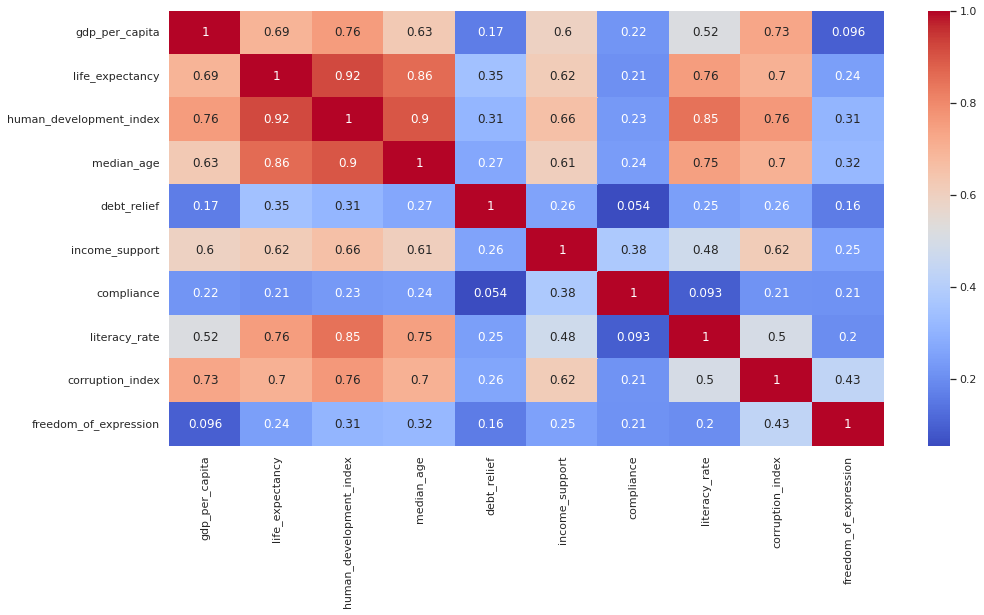

In [ ]:
sns.heatmap(compliance_df.corr(), annot=True, cmap='coolwarm')

Identify outliers

In [ ]:
compliance_df.columns

Index(['country', 'gdp_per_capita', 'life_expectancy',
       'human_development_index', 'median_age', 'debt_relief',
       'income_support', 'compliance', 'literacy_rate', 'corruption_index',
       'freedom_of_expression'],
      dtype='object')

In [ ]:
# Calculate logs and squares and replot graph below
X, y = feature_engineering(compliance_df, 'compliance', keep_country=True)

In [ ]:
# # Investigating empty graphs
# x = X["human_development_index_log"]
# plt.scatter(x, y)
# a, b = np.polyfit(x, y, 1)

# plt.plot(x, a*x+b, color='red')
# plt.title('Correlation between {} and Compliance'.format(feature))
# plt.xlabel(feature)
# plt.ylabel('Compliance')

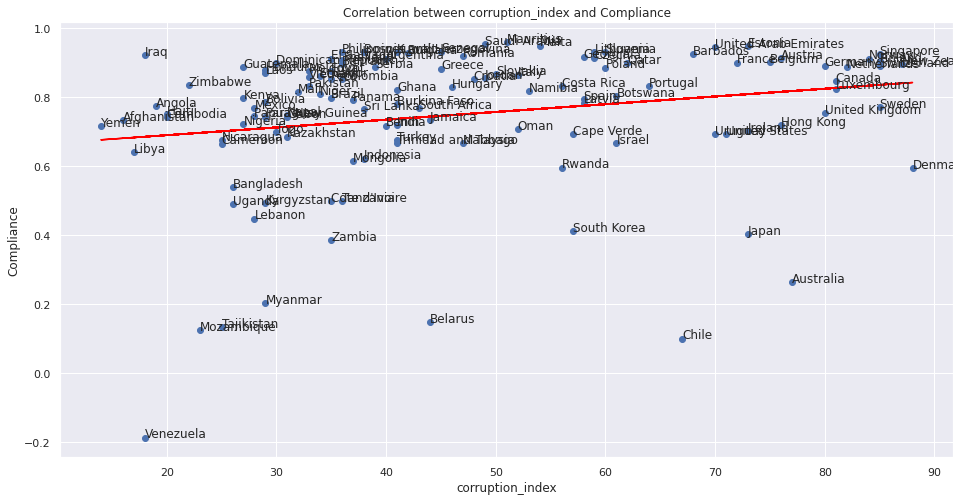

0.21334567625016806


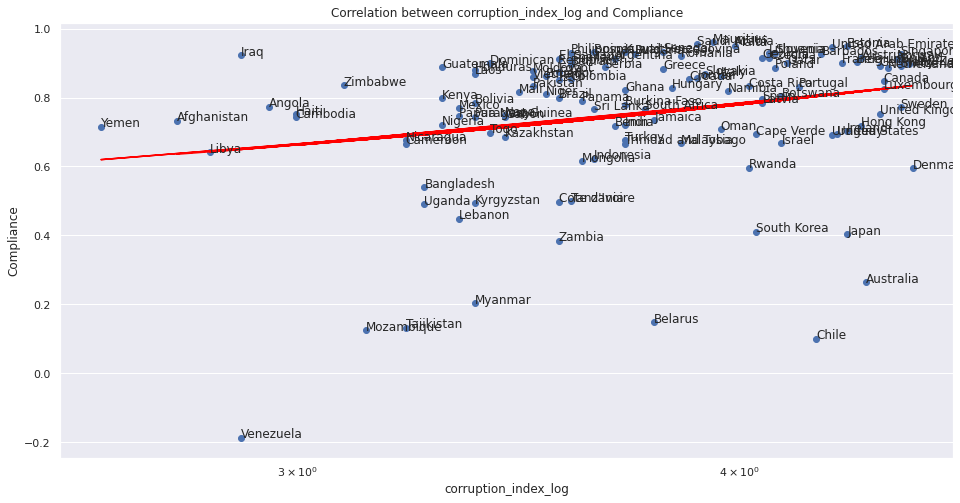

0.2466842428084898


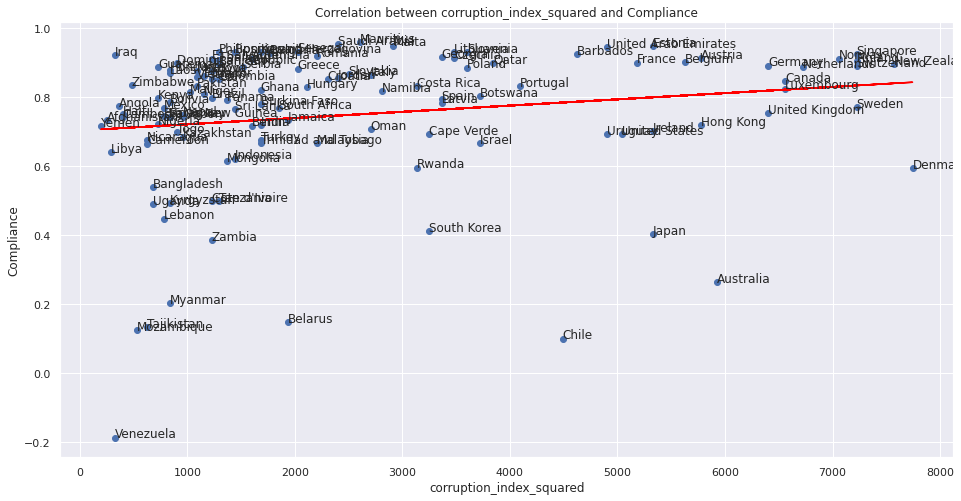

0.18065002469205133


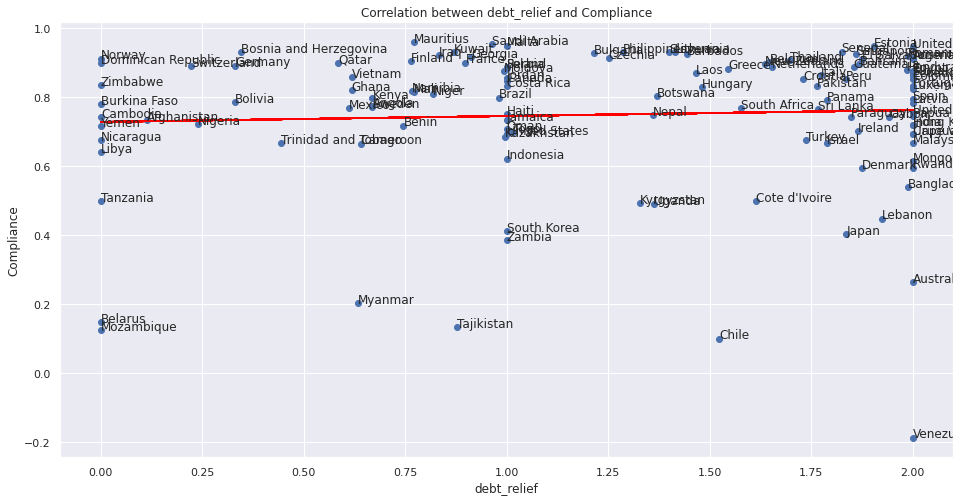

0.05441767471085604


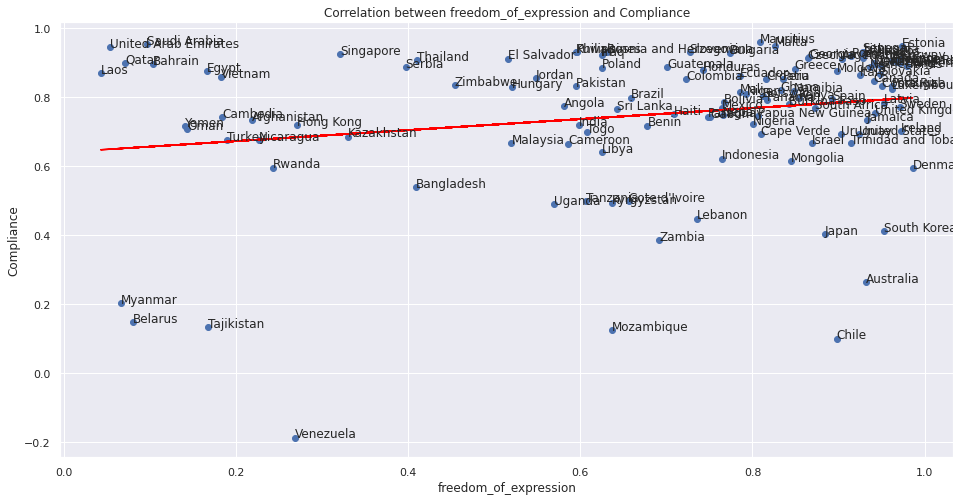

0.21303793999853968


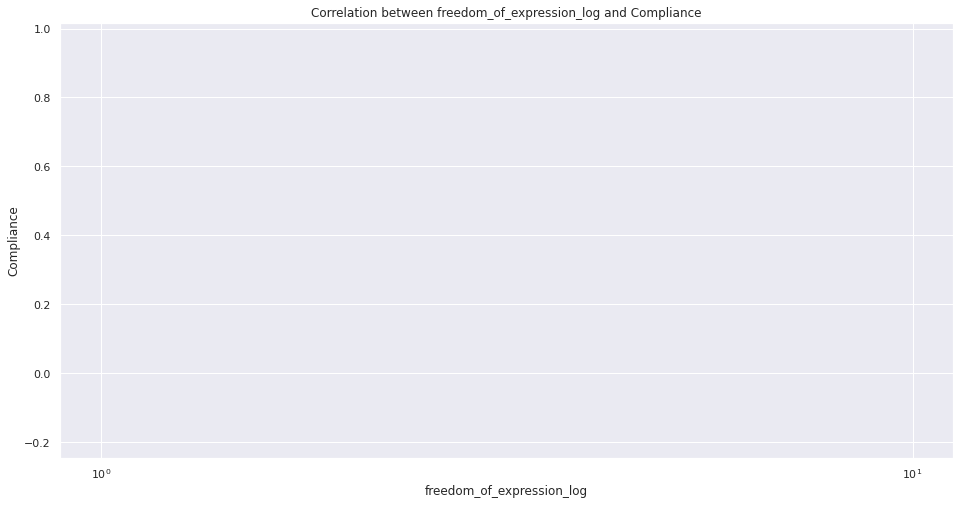

0.1811014882583179


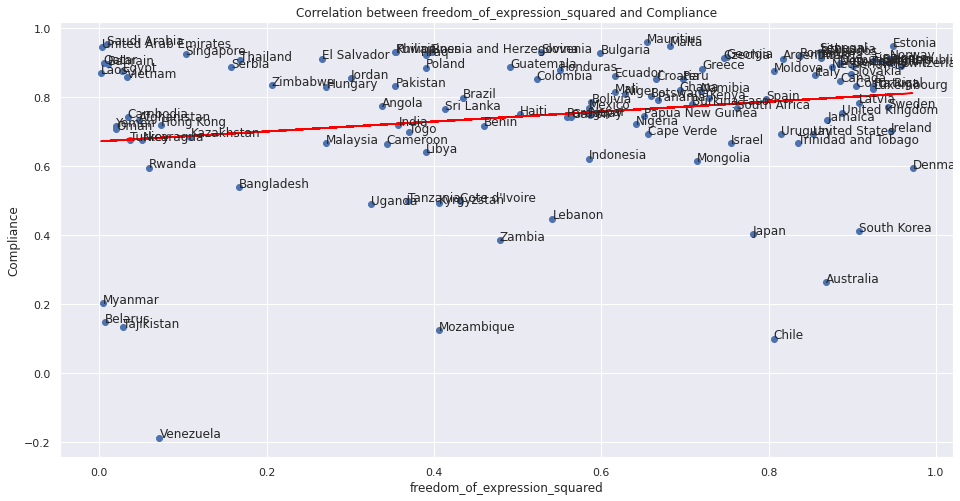

0.21618491921226726


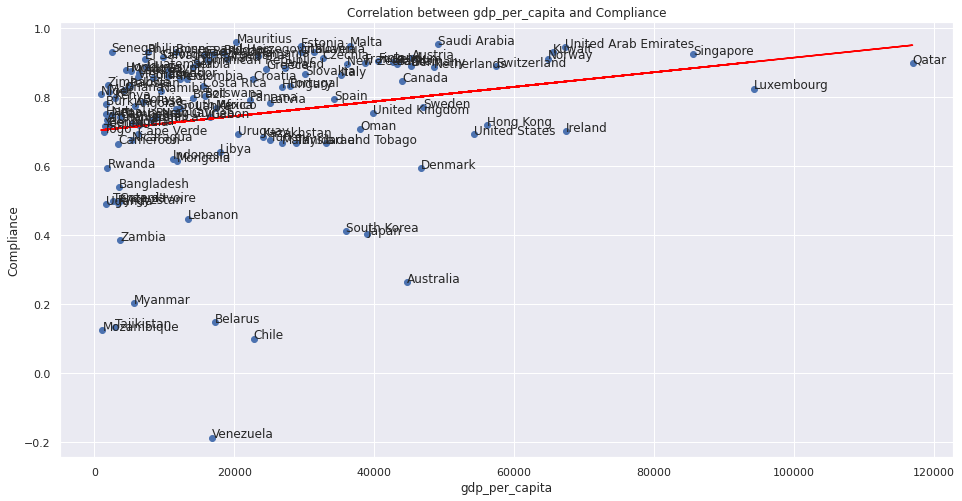

0.21729167517995124


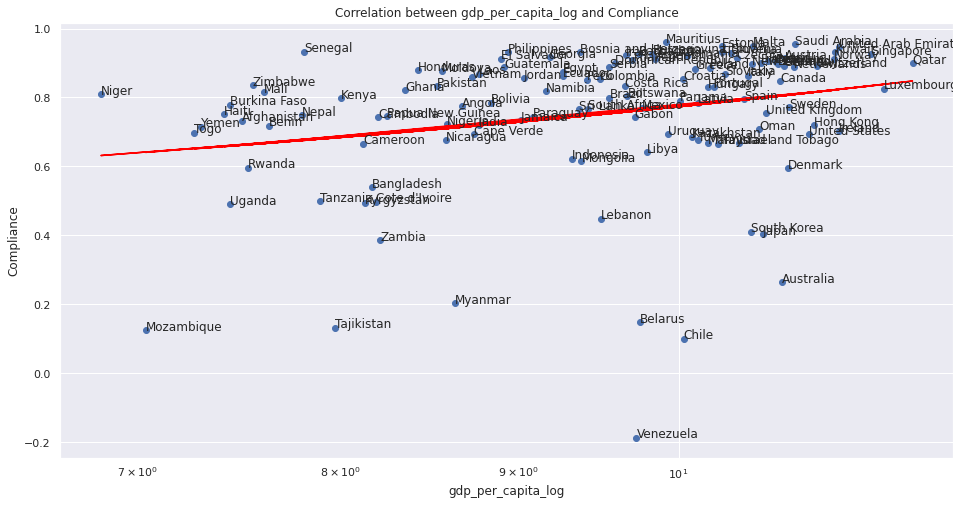

0.24607798427802421


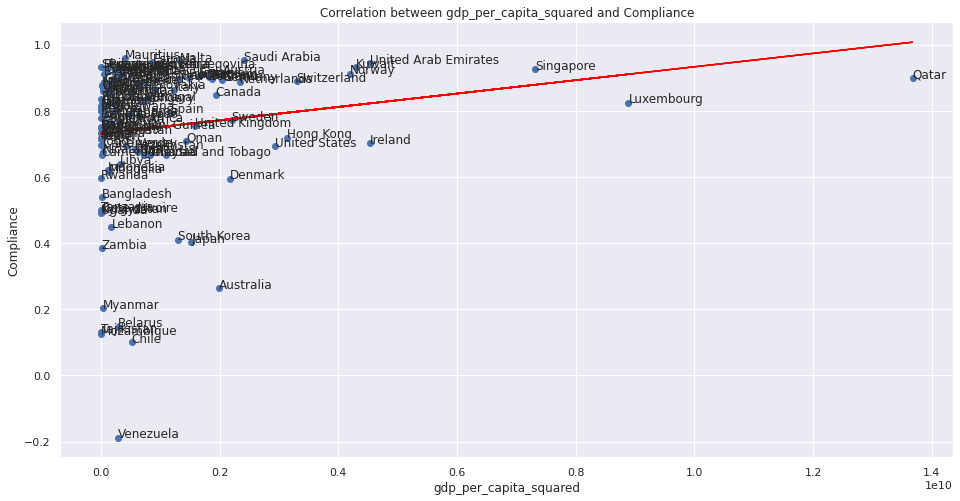

0.17733633908948904


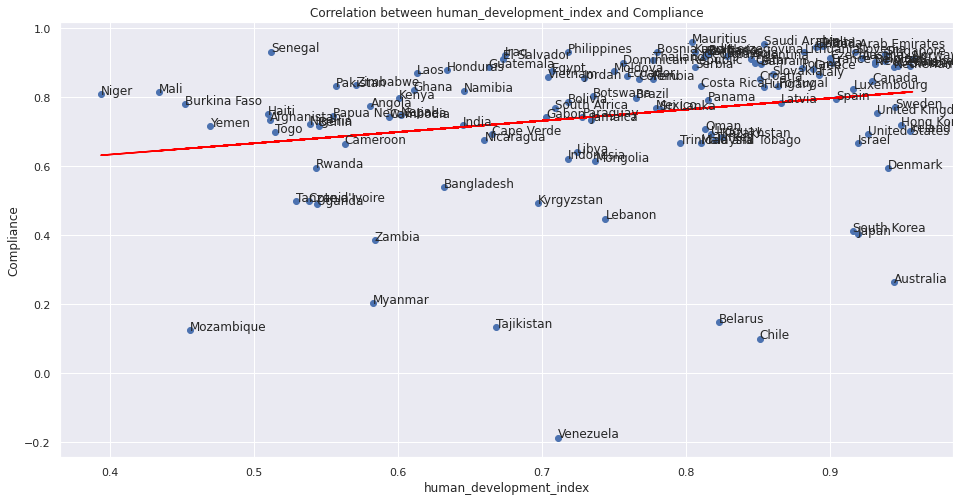

0.22997028900273223


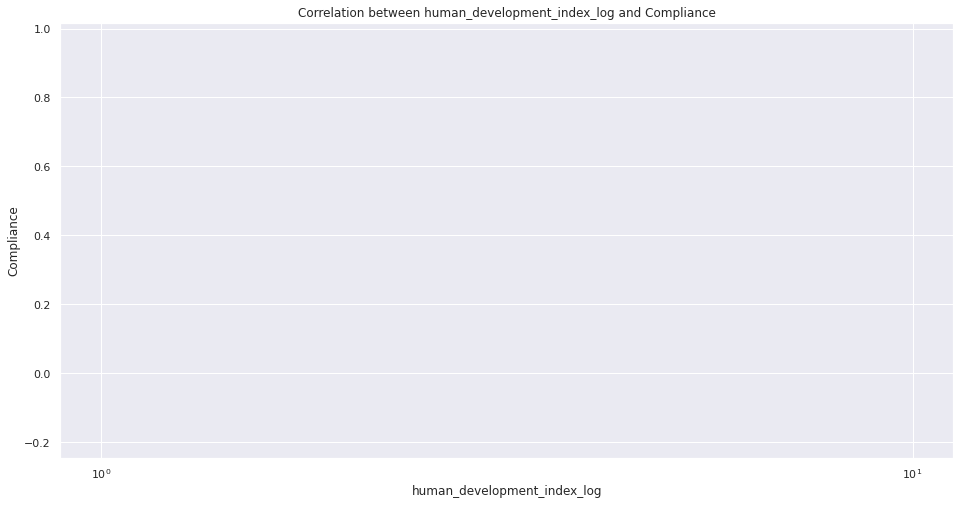

0.22714562316322362


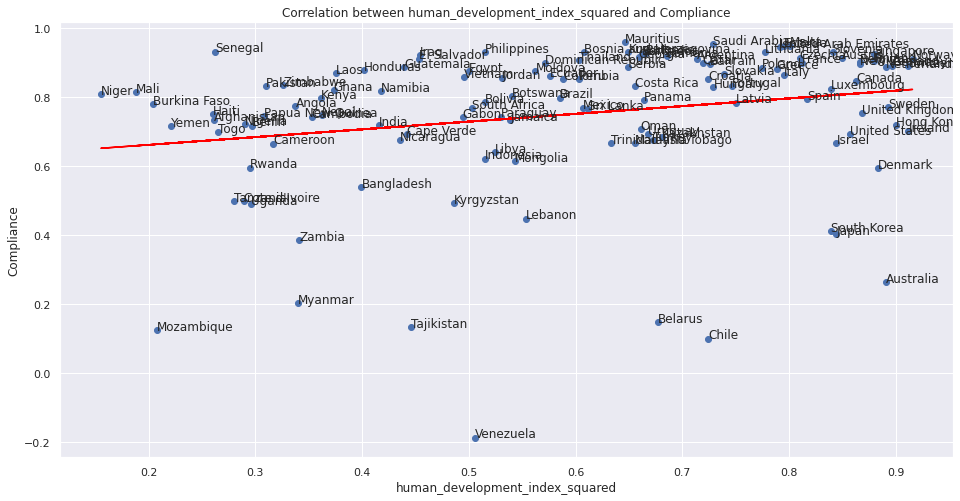

0.2284564196451767


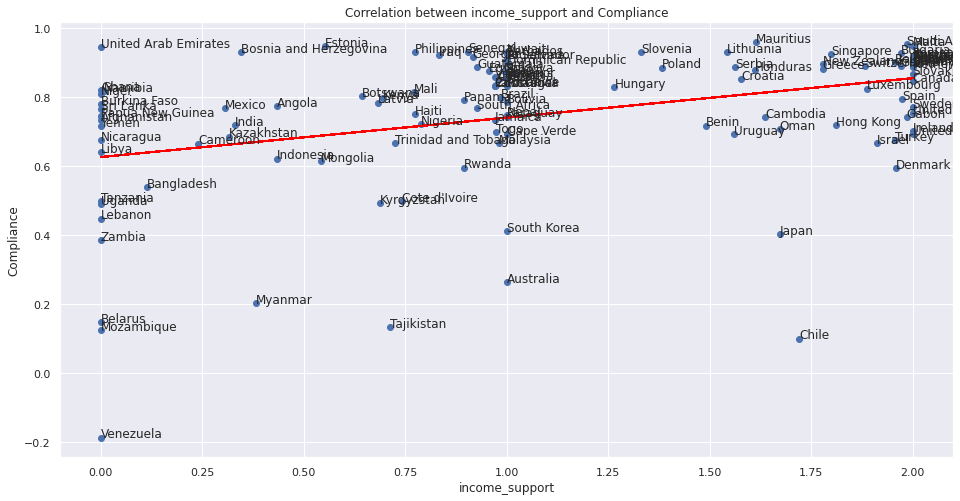

0.37907928909320004


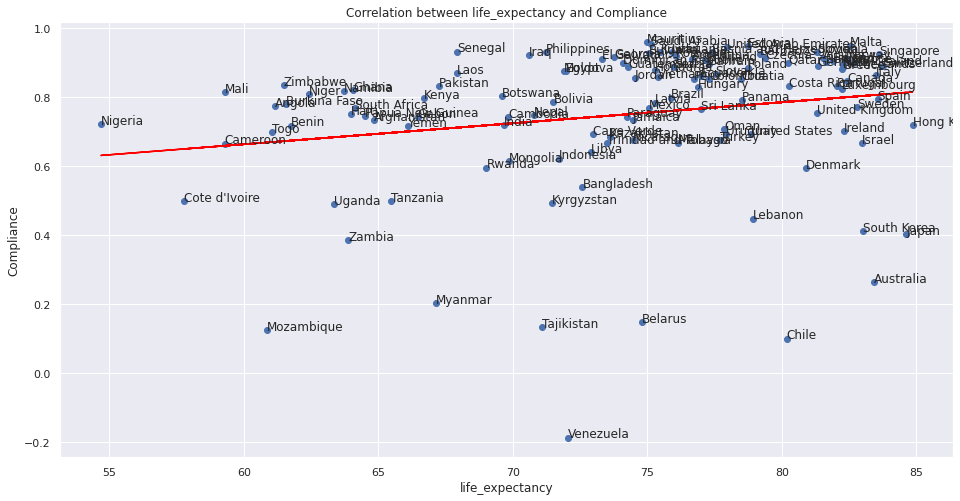

0.20874683560937068


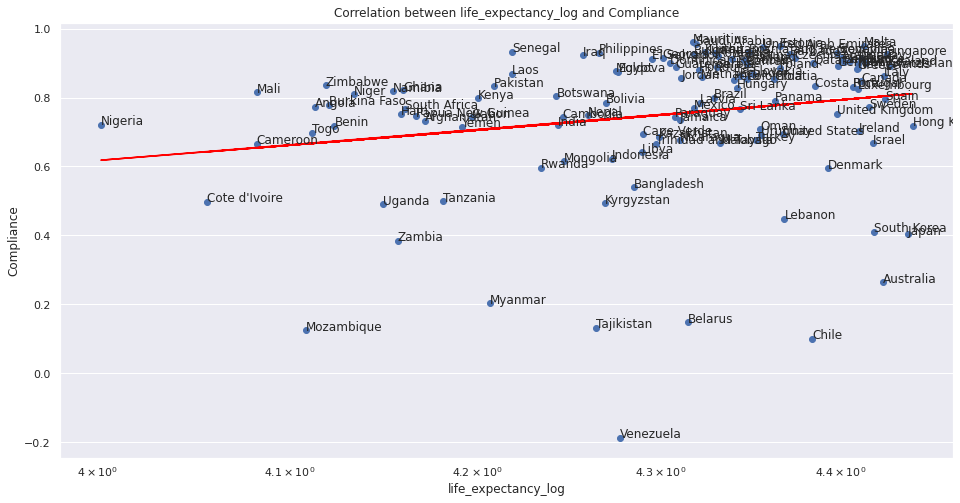

0.21053088072047071


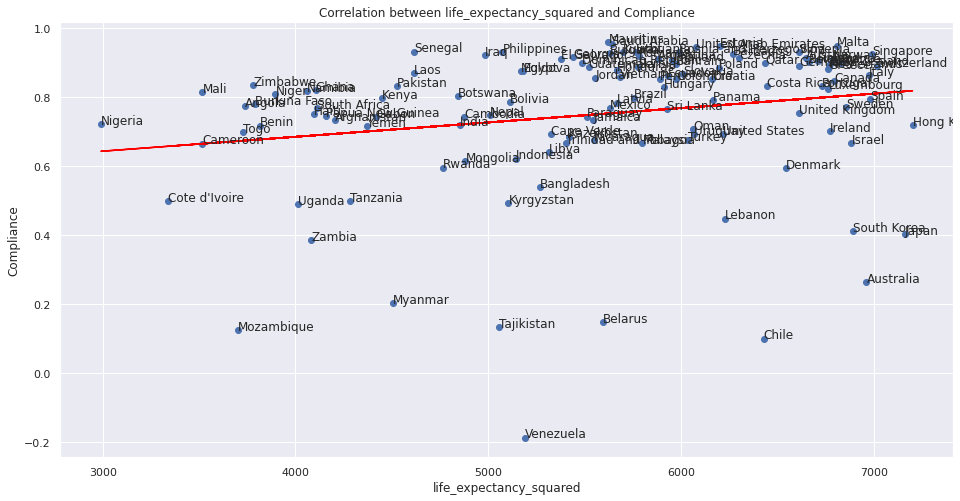

0.20589188714142723


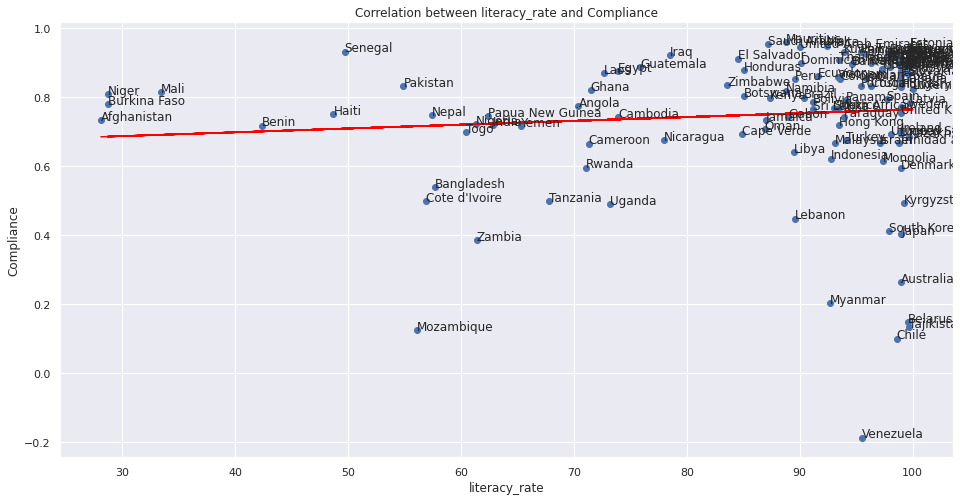

0.09333284262010454


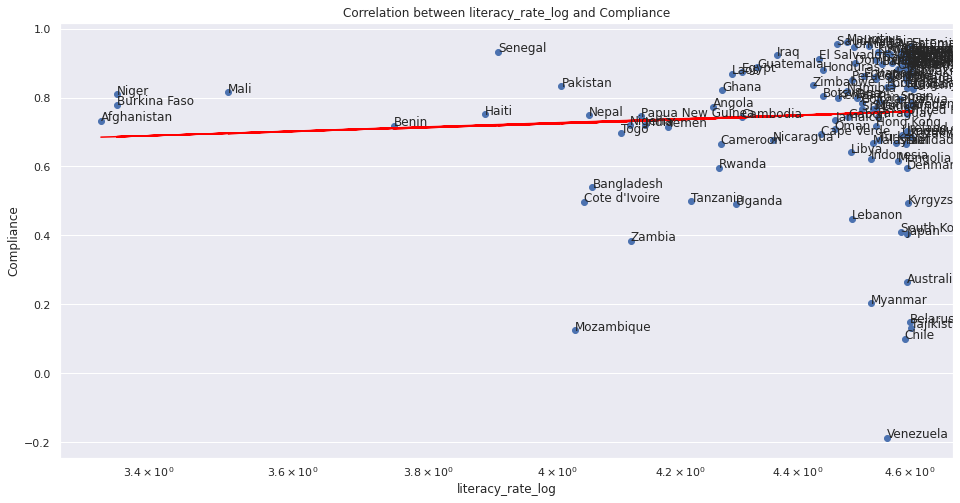

0.0761738406805778


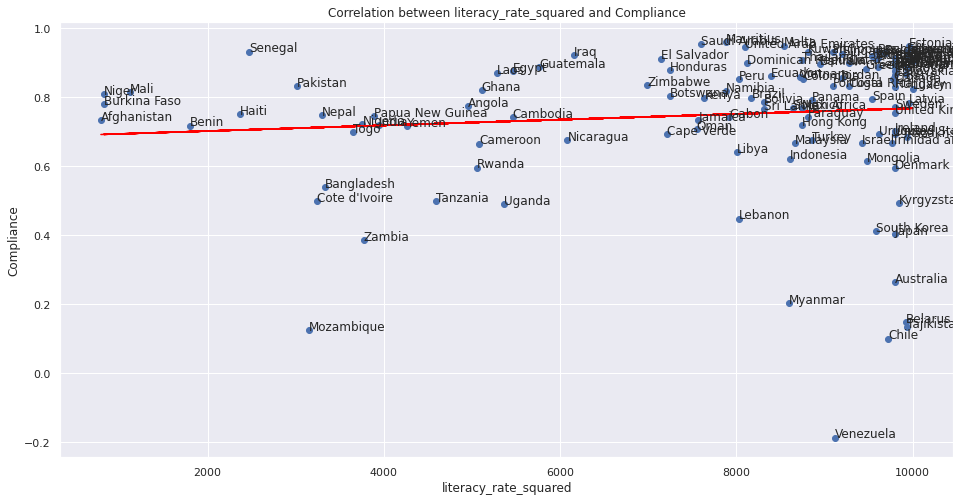

0.1013177127438721


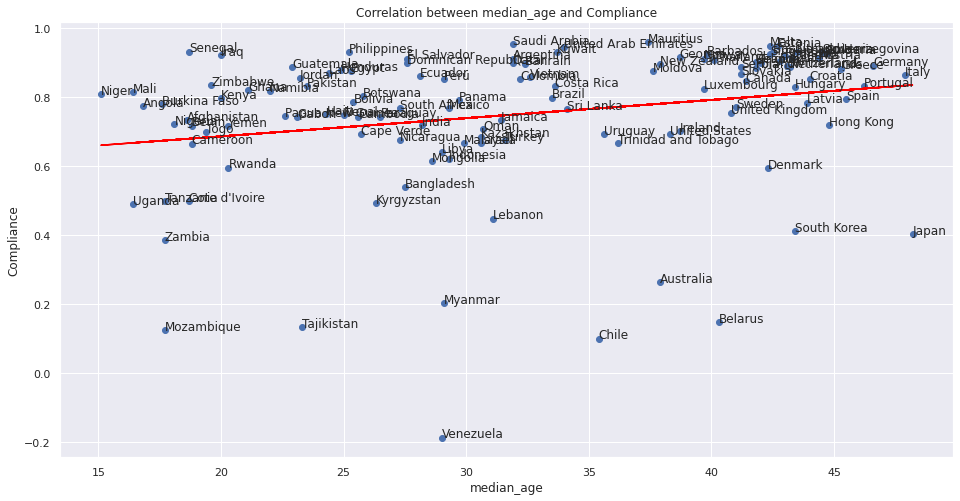

0.23617833055861753


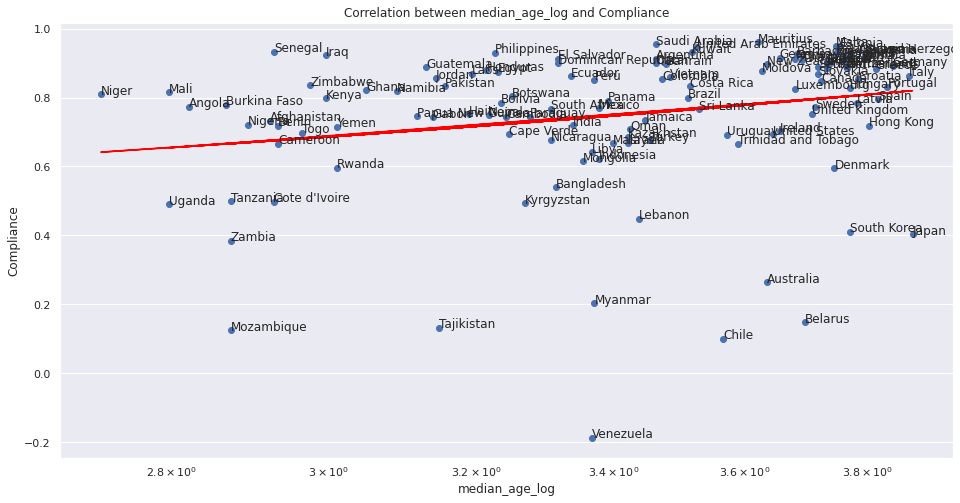

0.23057651237222457


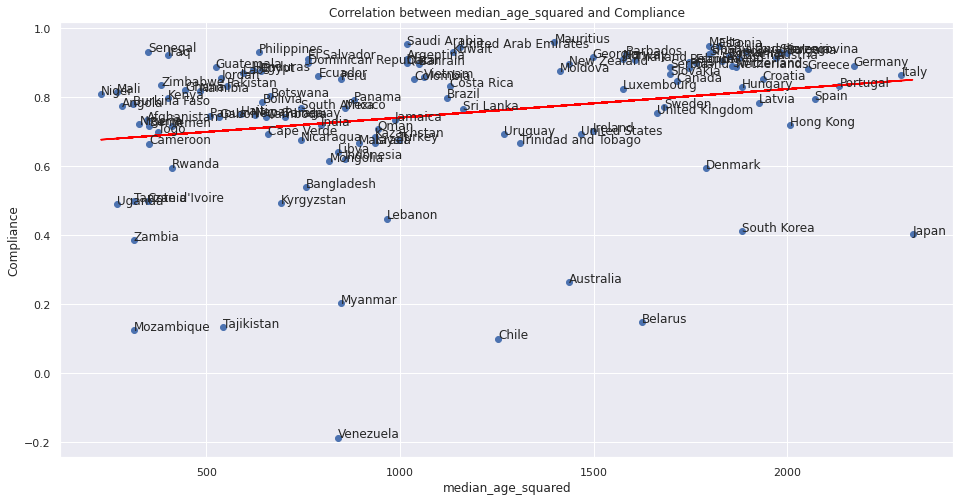

0.23763674223764253


In [ ]:
for feature in sorted(X.columns):
    try:
        if feature == 'country': # Skip the country column
            continue
        x = X[feature]
        plt.scatter(x, y)
        a, b = np.polyfit(x, y, 1)
        
        plt.plot(x, a*x+b, color='red')
        plt.title('Correlation between {} and Compliance'.format(feature))
        plt.xlabel(feature)
        plt.ylabel('Compliance')

        for i, txt in zip(X.index, X['country']):
            plt.annotate(txt, (x[i], y[i]), clip_on=True)

        if feature.endswith('log'):
            plt.xscale('log')
        else:
            plt.xscale('linear')
            
        plt.show()
        print(x.corr(y))
    except Exception as e:
        print(e)
        continue

##### Modelling:

In [ ]:
X, y = feature_engineering(compliance_df, 'compliance')
np.mean(y)

0.7496804358790291

In [ ]:
feature_importance_df = pd.DataFrame(columns=['feature', 'corr', 'corr_squared'])
for feature in X.columns[1:]:
    feature_importance_df = feature_importance_df.append(
        pd.Series((feature, X[feature].corr(y), X[feature].corr(y)**2), index = ['feature', 'corr', 'corr_squared']), 
           ignore_index=True)
feature_importance_df.sort_values(by='corr_squared', ascending=False, inplace=True)
feature_importance_df.head(15)

feature      corr  corr_squared
4                    income_support  0.372938      0.139083
18             corruption_index_log  0.237288      0.056306
8                gdp_per_capita_log  0.236338      0.055856
15               median_age_squared  0.222979      0.049720
2                        median_age  0.221472      0.049050
1           human_development_index  0.218575      0.047775
13  human_development_index_squared  0.217079      0.047123
14                   median_age_log  0.216277      0.046776
12      human_development_index_log  0.215933      0.046627
21    freedom_of_expression_squared  0.206123      0.042487
7             freedom_of_expression  0.203738      0.041509
6                  corruption_index  0.203723      0.041503
10              life_expectancy_log  0.196554      0.038634
0                   life_expectancy  0.194197      0.037712
11          life_expectancy_squared  0.190806      0.036407

In [ ]:
insample_rsquared(X, y)

0.44231540373108635

In [ ]:
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     3.207
Date:                Wed, 04 May 2022   Prob (F-statistic):           3.80e-05
Time:                        00:03:33   Log-Likelihood:                 51.620
No. Observations:                 117   AIC:                            -55.24
Df Residuals:                      93   BIC:                             11.05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             249.1777    142.951      1.743      0.085     -34.695     533.050
gdp_per_capita                   -7.58e-06   8.94e-06     -0.848      0.399   -2.53e-05    1.02e-05
life_expectancy                     2.8728      1.459      1.969      0.052      -0.025       5.770
human_development_index            12.3606     25.417      0.486      0.628     -38.113      62.835
median_age                         -0.3122      0.201     -1.550      0.125      -0.712       0.088
debt_relief                        -0.0310      0.029     -1.053      0.295      -0.089       0.027
income_support                      0.1285      0.034      3.771      0.000       0.061       0.196
literacy_rate                       0.2859      0.078      3.645      0.000       0.130       0.442
corruption_index                   -0.0159      0.029     -0.547      0.586      -0.074       0.042
freedom_of_expression               1.4074      1.119      1.257      0.212      -0.815       3.630
gdp_per_capita_log                 -0.0052      0.099     -0.053      0.958      -0.202       0.191
gdp_per_capita_squared           8.492e-11   6.03e-11      1.408      0.162   -3.48e-11    2.05e-10
life_expectancy_log               -92.6543     50.387     -1.839      0.069    -192.714       7.405
life_expectancy_squared            -0.0110      0.005     -2.106      0.038      -0.021      -0.001
human_development_index_log        -4.6636      7.984     -0.584      0.561     -20.519      11.192
human_development_index_squared    -2.8507      9.755     -0.292      0.771     -22.222      16.521
median_age_log                      4.2594      2.935      1.451      0.150      -1.569      10.087
median_age_squared                  0.0028      0.002      1.696      0.093      -0.000       0.006
literacy_rate_log                  -7.9322      2.241     -3.540      0.001     -12.382      -3.483
literacy_rate_squared              -0.0012      0.000     -3.862      0.000      -0.002      -0.001
corruption_index_log                0.3957      0.599      0.661      0.511      -0.794       1.585
corruption_index_squared         7.395e-05      0.000      0.464      0.644      -0.000       0.000
freedom_of_expression_log          -0.1459      0.181     -0.807      0.422      -0.505       0.213
freedom_of_expression_squared      -0.7736      0.660     -1.172      0.244      -2.084       0.537
==============================================================================
Omnibus:                       18.090   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.690
Skew:                          -0.824   Prob(JB):                     7.18e-06
Kurtosis:                       4.464   Cond. No.                  

---

In [ ]:
forward_included = forward_regression(X, y)
backward_included = backward_regression(X, y)

In [ ]:
forward_included

['income_support']

In [ ]:
insample_rsquared(X[forward_included], y)

0.13908263989765723

In [ ]:
sm.OLS(y, sm.add_constant(X[forward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     18.58
Date:                Wed, 04 May 2022   Prob (F-statistic):           3.46e-05
Time:                        00:03:34   Log-Likelihood:                 26.219
No. Observations:                 117   AIC:                            -48.44
Df Residuals:                     115   BIC:                            -42.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6259      0.033     18.824      0.000       0.560       0.692
income_support     0.1132      0.026      4.310      0.000       0.061       0.165
==============================================================================
Omnibus:                       53.817   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.676
Skew:                          -1.817   Prob(JB):                     7.71e-31
Kurtosis:                       6.905   Cond. No.                         3.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

In [ ]:
backward_included

['life_expectancy',
 'income_support',
 'literacy_rate',
 'freedom_of_expression',
 'gdp_per_capita_squared',
 'life_expectancy_log',
 'life_expectancy_squared',
 'median_age_squared',
 'literacy_rate_log',
 'literacy_rate_squared']

In [ ]:
insample_rsquared(X[backward_included], y)

0.3866511933808787

In [ ]:
sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     6.682
Date:                Wed, 04 May 2022   Prob (F-statistic):           5.58e-08
Time:                        00:03:36   Log-Likelihood:                 46.054
No. Observations:                 117   AIC:                            -70.11
Df Residuals:                     106   BIC:                            -39.72
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     247.7772    106.639      2.324      0.022      36.354     459.200
life_expectancy             2.6268      1.104      2.379      0.019       0.438       4.816
income_support              0.1317      0.031      4.186      0.000       0.069       0.194
literacy_rate               0.2722      0.067      4.054      0.000       0.139       0.405
freedom_of_expression       0.2669      0.070      3.830      0.000       0.129       0.405
gdp_per_capita_squared   3.218e-11   1.22e-11      2.641      0.010    8.02e-12    5.63e-11
life_expectancy_log       -85.5451     38.724     -2.209      0.029    -162.319      -8.771
life_expectancy_squared    -0.0100      0.004     -2.553      0.012      -0.018      -0.002
median_age_squared          0.0002   5.97e-05      3.198      0.002    7.26e-05       0.000
literacy_rate_log          -7.6050      1.910     -3.982      0.000     -11.391      -3.819
literacy_rate_squared      -0.0011      0.000     -4.206      0.000      -0.002      -0.001
==============================================================================
Omnibus:                       30.903   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.991
Skew:                          -1.114   Prob(JB):                     1.55e-13
Kurtosis:                       5.672   Cond. No.                     1.36e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

Top 10 compliant countries

In [ ]:
compliance_df.columns

Index(['country', 'gdp_per_capita', 'life_expectancy',
       'human_development_index', 'median_age', 'debt_relief',
       'income_support', 'compliance', 'literacy_rate', 'corruption_index',
       'freedom_of_expression'],
      dtype='object')

In [ ]:
X, y = feature_engineering(compliance_df.sort_values('compliance', ascending=False).head(10), 'compliance')
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 04 May 2022   Prob (F-statistic):                nan
Time:                        00:03:36   Log-Likelihood:                 210.70
No. Observations:                  10   AIC:                            -401.4
Df Residuals:                       0   BIC:                            -398.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0005        inf          0        nan         nan         nan
gdp_per_capita                   1.241e-06        inf          0        nan         nan         nan
life_expectancy                     0.0179        inf          0        nan         nan         nan
human_development_index            -0.0002        inf         -0        nan         nan         nan
median_age                          0.0041        inf          0        nan         nan         nan
debt_relief                         0.0002        inf          0        nan         nan         nan
income_support                     -0.0025        inf         -0        nan         nan         nan
literacy_rate                       0.0065        inf          0        nan         nan         nan
corruption_index                   -0.0026        inf         -0        nan         nan         nan
freedom_of_expression               0.0014        inf          0        nan         nan         nan
gdp_per_capita_log                  0.0023        inf          0        nan         nan         nan
gdp_per_capita_squared          -2.025e-11        inf         -0        nan         nan         nan
life_expectancy_log                 0.0018        inf          0        nan         nan         nan
life_expectancy_squared            -0.0001        inf         -0        nan         nan         nan
human_development_index_log        -0.0009        inf         -0        nan         nan         nan
human_development_index_squared    -0.0005        inf         -0        nan         nan         nan
median_age_log                      0.0011        inf          0        nan         nan         nan
median_age_squared              -6.456e-05        inf         -0        nan         nan         nan
literacy_rate_log                   0.0015        inf          0        nan         nan         nan
literacy_rate_squared           -4.907e-05        inf         -0        nan         nan         nan
corruption_index_log                0.0011        inf          0        nan         nan         nan
corruption_index_squared         2.645e-05        inf          0        nan         nan         nan
freedom_of_expression_log           0.0023        inf          0        nan         nan         nan
freedom_of_expression_squared       0.0020        inf          0        nan         nan         nan
==============================================================================
Omnibus:                       17.917   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.169
Skew:                           1.963   Prob(JB):                      0.00619
Kurtosis:                       5.998   Cond. No.                  

---
**Note:**  
Taiwan has no GDP per capita  
Aruba, Belize and Fiji have no perceived corruption index

Europe

In [ ]:
continent_dict = {}
for name, group in merged_df.groupby('continent'):
    continent_dict[name] = set(group['country'])

X, y = feature_engineering(compliance_df[compliance_df['country'].isin(continent_dict['Europe'])], 'compliance')
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     8.617
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000654
Time:                        00:03:37   Log-Likelihood:                 60.436
No. Observations:                  31   AIC:                            -78.87
Df Residuals:                      10   BIC:                            -48.76
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              14.9138    539.100      0.028      0.978   -1186.275    1216.103
gdp_per_capita                   3.708e-05   6.26e-05      0.593      0.567      -0.000       0.000
life_expectancy                     1.4328     51.927      0.028      0.979    -114.267     117.133
human_development_index          -957.5474   1325.636     -0.722      0.487   -3911.248    1996.153
median_age                        -22.2078     17.306     -1.283      0.228     -60.769      16.353
debt_relief                        -0.0300      0.035     -0.858      0.411      -0.108       0.048
income_support                      0.0569      0.055      1.041      0.323      -0.065       0.179
literacy_rate                      -5.8131     32.061     -0.181      0.860     -77.250      65.624
corruption_index                    0.6744      0.229      2.947      0.015       0.164       1.184
freedom_of_expression               1.1914      3.344      0.356      0.729      -6.259       8.641
gdp_per_capita_log                 -0.6004      1.101     -0.545      0.597      -3.054       1.853
gdp_per_capita_squared          -1.951e-10   4.26e-10     -0.458      0.657   -1.14e-09    7.54e-10
life_expectancy_log               -57.0450   2052.662     -0.028      0.978   -4630.662    4516.572
life_expectancy_squared            -0.0045      0.164     -0.027      0.979      -0.370       0.361
human_development_index_log       427.2220    581.089      0.735      0.479    -867.524    1721.968
human_development_index_squared   268.0336    377.743      0.710      0.494    -573.630    1109.697
median_age_log                    495.7709    376.837      1.316      0.218    -343.875    1335.417
median_age_squared                  0.1242      0.099      1.252      0.239      -0.097       0.345
literacy_rate_log                  10.3804   1638.223      0.006      0.995   -3639.807    3660.568
literacy_rate_squared               0.0293      0.079      0.371      0.718      -0.146       0.205
corruption_index_log              -20.6176      7.372     -2.797      0.019     -37.043      -4.192
corruption_index_squared           -0.0027      0.001     -3.129      0.011      -0.005      -0.001
freedom_of_expression_log           0.1609      0.559      0.288      0.779      -1.085       1.407
freedom_of_expression_squared      -0.8418      1.746     -0.482      0.640      -4.732       3.048
==============================================================================
Omnibus:                        9.909   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.337
Skew:                           0.941   Prob(JB):                      0.00938
Kurtosis:                       4.920   Cond. No.                  

In [ ]:
forward_included = forward_regression(X, y)
backward_included = backward_regression(X, y)

In [ ]:
sm.OLS(y, sm.add_constant(X[forward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     45.31
Date:                Wed, 04 May 2022   Prob (F-statistic):           1.67e-09
Time:                        00:03:38   Log-Likelihood:                 37.813
No. Observations:                  31   AIC:                            -69.63
Df Residuals:                      28   BIC:                            -65.32
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.3416      0.087     15.401      0.000       1.163       1.520
freedom_of_expression_log         0.4696      0.054      8.670      0.000       0.359       0.581
freedom_of_expression_squared    -0.5194      0.099     -5.224      0.000      -0.723      -0.316
==============================================================================
Omnibus:                       12.480   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.116
Skew:                          -1.239   Prob(JB):                      0.00234
Kurtosis:                       4.799   Cond. No.                         13.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     20.28
Date:                Wed, 04 May 2022   Prob (F-statistic):           5.08e-08
Time:                        00:03:38   Log-Likelihood:                 56.903
No. Observations:                  31   AIC:                            -87.81
Df Residuals:                      18   BIC:                            -69.17
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          -881.1353    296.335     -2.973      0.008   -1503.712    -258.558
gdp_per_capita                 6.983e-06   1.97e-06      3.540      0.002    2.84e-06    1.11e-05
median_age                      -25.2414      6.374     -3.960      0.001     -38.632     -11.850
income_support                    0.0873      0.028      3.081      0.006       0.028       0.147
literacy_rate                    -7.3008      1.709     -4.273      0.000     -10.890      -3.711
corruption_index                  0.6711      0.103      6.537      0.000       0.455       0.887
freedom_of_expression             1.7832      0.293      6.095      0.000       1.169       2.398
median_age_log                  562.1363    137.269      4.095      0.001     273.745     850.528
median_age_squared                0.1415      0.037      3.831      0.001       0.064       0.219
literacy_rate_squared             0.0374      0.009      4.287      0.000       0.019       0.056
corruption_index_log            -20.5758      3.103     -6.630      0.000     -27.096     -14.056
corruption_index_squared         -0.0027      0.000     -6.452      0.000      -0.004      -0.002
freedom_of_expression_squared    -1.1298      0.236     -4.786      0.000      -1.626      -0.634
==============================================================================
Omnibus:                        2.577   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.276   Jarque-Bera (JB):                1.454
Skew:                           0.494   Prob(JB):                        0.483
Kurtosis:                       3.385   Cond. No.                     1.37e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

Compliance regressions by continent

In [ ]:
continent_dict = {}
for name, group in merged_df.groupby('continent'):
    continent_dict[name] = set(group['country'])

    X, y = feature_engineering(compliance_df[compliance_df['country'].isin(continent_dict[name])], 'compliance')
    print(f"{name} ({len(continent_dict[name])} countries)",":", "In-sample r-squared:", insample_rsquared(X, y))
    backward_included = backward_regression(X, y)
    print("OLS regression with backward selected features:")
    print(sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary())
    print(X[backward_included].std())
    print("-"*20, "\n")

Africa (56 countries) : In-sample r-squared: 0.9996393979524602
OLS regression with backward selected features:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     13.07
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000493
Time:                        00:03:38   Log-Likelihood:                 48.294
No. Observations:                  25   AIC:                            -62.59
Df Residuals:                       8   BIC:                            -41.87
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975

---

Dummy vars for continent

In [ ]:
X, y = feature_engineering(compliance_df, 'compliance', keep_country=True)
X['continent'] = X['country'].apply(lambda x: merged_df[merged_df['country'] == x]['continent'].values[0])
X = pd.get_dummies(X, columns=['continent'])
X.drop(columns=['country'], inplace=True)
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     2.983
Date:                Wed, 04 May 2022   Prob (F-statistic):           5.30e-05
Time:                        00:03:41   Log-Likelihood:                 56.497
No. Observations:                 117   AIC:                            -54.99
Df Residuals:                      88   BIC:                             25.11
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             156.8949    131.887      1.190      0.237    -105.203     418.992
gdp_per_capita                  -7.769e-06   9.03e-06     -0.860      0.392   -2.57e-05    1.02e-05
life_expectancy                     2.1843      1.584      1.379      0.171      -0.963       5.332
human_development_index            31.0934     26.286      1.183      0.240     -21.145      83.332
median_age                         -0.2636      0.203     -1.300      0.197      -0.667       0.139
debt_relief                        -0.0229      0.031     -0.749      0.456      -0.084       0.038
income_support                      0.1316      0.034      3.857      0.000       0.064       0.199
literacy_rate                       0.3075      0.079      3.872      0.000       0.150       0.465
corruption_index                   -0.0086      0.029     -0.297      0.767      -0.066       0.049
freedom_of_expression               1.4792      1.120      1.321      0.190      -0.746       3.705
gdp_per_capita_log                 -0.0072      0.099     -0.073      0.942      -0.203       0.189
gdp_per_capita_squared           8.455e-11   6.07e-11      1.394      0.167    -3.6e-11    2.05e-10
life_expectancy_log               -70.9233     54.386     -1.304      0.196    -179.004      37.157
life_expectancy_squared            -0.0084      0.006     -1.464      0.147      -0.020       0.003
human_development_index_log       -10.3519      8.215     -1.260      0.211     -26.678       5.975
human_development_index_squared   -10.2303     10.135     -1.009      0.316     -30.371       9.910
median_age_log                      3.6713      2.974      1.234      0.220      -2.240       9.582
median_age_squared                  0.0022      0.002      1.349      0.181      -0.001       0.006
literacy_rate_log                  -8.4671      2.250     -3.764      0.000     -12.938      -3.997
literacy_rate_squared              -0.0013      0.000     -4.079      0.000      -0.002      -0.001
corruption_index_log                0.2410      0.598      0.403      0.688      -0.948       1.430
corruption_index_squared           4.5e-05      0.000      0.282      0.778      -0.000       0.000
freedom_of_expression_log          -0.1385      0.182     -0.761      0.448      -0.500       0.223
freedom_of_expression_squared      -0.8447      0.661     -1.278      0.205      -2.158       0.469
continent_Africa                   26.0887     22.003      1.186      0.239     -17.637      69.814
continent_Asia                     26.1689     21.985      1.190      0.237     -17.522      69.860
continent_Europe                   26.2692     21.965      1.196      0.235     -17.381      69.919
continent_North America            26.1602     21.973      1.191      0.237     -17

In [ ]:
forward_included = forward_regression(X, y)
backward_included = backward_regression(X, y)

In [ ]:
sm.OLS(y, sm.add_constant(X[forward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     18.58
Date:                Wed, 04 May 2022   Prob (F-statistic):           3.46e-05
Time:                        00:03:42   Log-Likelihood:                 26.219
No. Observations:                 117   AIC:                            -48.44
Df Residuals:                     115   BIC:                            -42.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6259      0.033     18.824      0.000       0.560       0.692
income_support     0.1132      0.026      4.310      0.000       0.061       0.165
==============================================================================
Omnibus:                       53.817   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.676
Skew:                          -1.817   Prob(JB):                     7.71e-31
Kurtosis:                       6.905   Cond. No.                         3.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     6.960
Date:                Wed, 04 May 2022   Prob (F-statistic):           2.28e-07
Time:                        00:03:43   Log-Likelihood:                 41.782
No. Observations:                 117   AIC:                            -65.56
Df Residuals:                     108   BIC:                            -40.70
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              16.9766      4.910      3.458      0.001       7.244      26.709
human_development_index             4.7771      1.731      2.760      0.007       1.347       8.207
income_support                      0.1265      0.033      3.874      0.000       0.062       0.191
literacy_rate                       0.2490      0.069      3.627      0.000       0.113       0.385
freedom_of_expression               0.1418      0.066      2.144      0.034       0.011       0.273
human_development_index_squared    -2.9626      1.132     -2.617      0.010      -5.207      -0.719
literacy_rate_log                  -7.1805      1.940     -3.701      0.000     -11.027      -3.335
literacy_rate_squared              -0.0010      0.000     -3.733      0.000      -0.002      -0.000
continent_Europe                    0.1578      0.050      3.136      0.002       0.058       0.257
==============================================================================
Omnibus:                       28.594   Durbin-Watson:                   2.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.433
Skew:                          -1.029   Prob(JB):                     1.51e-12
Kurtosis:                       5.632   Cond. No.                     2.65e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""